# <font color='red'>1. Business Understanding</font>

The first step in a Data Science project involve to understand the business problem, formulate that problem in a question, define the objective of the project, elaborate the hypothesis and design the strategy that will be followed to achieve that objective and solve the business problem. This is done here, in the **Business Understanding** section.

<font color='red'>1. Business Understanding</font>

**The All Insurance Company**

**Business Problem**

The company has 127.000 potential customer to accept a new car insurance proposal but is able to call to only 20.000 customers. Which customers should the company sellers prioritize to call to?

**Business problem in terms of expected value**

Knowing the customers with higher probability of accepting the new insurance proposal, the insurance company will gain efficacy and optimization of its processes by addressing your team to those customers. This gain in efficacy means optimal use of resources (people, time), which lead to the achievement of a useful goal (delivery of the proposal to the higher probability customers).

**Objective of this Project**

Identify and list the 20.000 potential customers with higer propobability of accepting a new car insurance proposal.

**Hypothesis**

**1.** The lower the age, the greater the chance of accepting the new insurance proposal.

**2.** Women take more insurance than men.

**3.** People paying a lower annual premium have a greater chance to accept new car insurance proposal.

**4.** Peopĺe who have already damage a car have higher probability of accepting a car insurance.

**5.** People with previous ensurance has greater chance to accept the car insurance proposal.

**6.** Regions with more traffic and accidents have more people willing to purchase car insurance.

**7.** People who doesn't have a driving license will not accept the new car insurance.

**8.** People with newer car have more chance to purchase a car insurance.

**9.** Older customers have higher probability to accept a proposal to purchase a car insurance from the All Insurance company.

**Deliverables**
- A list with 20.000 potential customers most likely to accept a car insurance proposal.
    - A prediction model that will predict the probabilities of potential customers to accept a car insurance proposal;
    - An application that a employee can insert a potential customer's name and get his/her probability of accepting a car insurance proposal.
- The model will be stored in the cloud and will be accessed by Google Sheets.

**Strategy to Solve the Business Problem**

Steps 2 to 6 represents the strategy adopted in this project to solve the business problem described above.

<font color='red'>2. Data Understanding</font>:

- Data Collection
- Data Description
    - Data Structure
        - Feature Description
        - Dimension
        - Types
    - Data cleaning
        - Columns Treatment
        - NA's Treatment
        - Types Treatment
    - Descriptive analysis
        - Response Attributes
        - Numerical Attributes
        - Categorical Attributes
- Final Hypothesis
    - Mind Map
    - Final Hypothesis
- Feature Engineeering
- Filtering variables by business restrictions
- Exploratory data analysis
    - Univariate analysis
    - Bivariate analysis
    - Multivariate analysis
        - Numerical Attributes
        - Categorical Attributes
    - Hypothesis Summary

<font color='red'>3. Data Preparation</font>

- Transformations
    - Normalization
    - Rescaling
    - Enconding
- Feature Selection

<font color='red'>4. Modeling</font>

- Machine Learning Models
- Compare Model Performance
- Hyperparameter fine tunning
- Final Model

<font color='red'>5. Evaluation: Metrics and Error Interpretation</font>

- Business Performance
- Total Performance
- Machine Learning Performance

<font color='red'>6. Deployment</font>

- Class
- API Handler
- API Tester

# Setup

## Importing Packages

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

import inflection
from scipy import stats as ss

from imblearn import under_sampling, over_sampling, combine

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from IPython.core.display import HTML
from IPython.display import Image

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Models and Metrics
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.metrics import roc_auc_score, top_k_accuracy_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split 

## Helper Functions

### Settings

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('seaborn')
    plt.rcParams['axes.labelsize']  = 22
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.figsize']  = [22,8]
    display( HTML('<style>.container {width:70% !important;}</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### EDA

In [3]:
# Descriptive Statistics function
# valid only for numerical attriubutes
def num_stats(num_attr):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame( num_attr.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attr.apply( np.median ) ).T

    # Dispersion - standard deviation (std), min, max, skew, kurtosis
    d1 = pd.DataFrame( num_attr.apply( np.std ) ).T
    d2 = pd.DataFrame( num_attr.apply( min ) ).T
    d3 = pd.DataFrame( num_attr.apply( max ) ).T

    # Dispersion - values' Range
    d4 = pd.DataFrame( num_attr.apply( lambda x: x.max() - x.min() ) ).T

    # Dispersion - skew and kurtosis
    d5 = pd.DataFrame( num_attr.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( num_attr.apply( lambda x: x.kurtosis() ) ).T

    # Concatenate all data frames
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    # display dataframe
    return m

In [4]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr-1, rcorr-1))).astype(float64)

In [5]:
def correlation_verifier(data, threshold, numerical=True):
    attributes_list = data.columns.tolist()

    df_corr = pd.DataFrame()
    for i in range(len(attributes_list)):
        for j in range(len(attributes_list)):
            ref = attributes_list[i]
            feat = attributes_list[j]

            # correlation
            if numerical:
                corr = data[ref].corr(data[feat], method='pearson')
            else:
                corr = cramer_v(data[ref], data[feat])

            if (ref != feat) and ((corr >= threshold) or (corr <= -threshold)):
                df_ref_feat = pd.DataFrame({ref: corr}, index=[feat])
                df_corr = pd.concat((df_corr, df_ref_feat))

    df_corr.fillna('--', inplace=True)

    if df_corr.empty:
        print('Theres is no strong correlation in this dataset.')
    else:
        print(df_corr)
    
    return df_corr

### Metrics

In [6]:
def precision_at_k(data, model_predict, k):
    # Propensity score
    data['score'] = model_predict[:, 1].tolist()

    # Sort clients by propensity score
    data = data.sort_values('score', ascending=False)
    
    # Reset index and create the column 'ranking'
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    
    # Calculte precision at k
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return (data.loc[k, 'precision_at_k'], data)

In [7]:
def recall_at_k(data, model_predict, k):
    # Propensity score
    data['score'] = model_predict[:, 1].tolist()

    # Sort clients by propensity score
    data = data.sort_values('score', ascending=False)
    
    # Reset index and create the column 'ranking'
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    
    # Calculate recall at k
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return (data.loc[k, 'recall_at_k'], data)

In [8]:
def cross_validation(model, X_train, y_train, num_fold, at_k):
    kfold = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=42)
    
    precision_list = []
    recall_list = []
    
    i = 1
    for train_index, test_index in kfold.split(X_train.values, y_train.values):
        
        X_train_fold = X_train.iloc[train_index]
        y_train_fold = y_train.iloc[train_index]

        X_test_fold = X_train.iloc[test_index]
        y_test_fold = y_train.iloc[test_index]

        fit = model.fit(X_train_fold, y_train_fold)
        predict_fold = fit.predict_proba(X_test_fold)
        precision_fold, _ = precision_at_k(pd.concat([X_test_fold, y_test_fold], axis=1), predict_fold, k=at_k)
        recall_fold, _ = recall_at_k(pd.concat([X_test_fold, y_test_fold], axis=1), predict_fold, k=at_k)
        
        precision_list.append(precision_fold)
        recall_list.append(recall_fold)
        
        print('Cross-Validation -> Fold: {}/{} - Precision: {} / Recall: {}'.format(i, num_fold, round(precision_fold, 4), round(recall_fold, 4)))
        
        i += 1
    
    precision_mean = mean(precision_list)
    recall_mean = mean(recall_list)
    
    results = {'precision': precision_mean,
               'recall': recall_mean}
    
    return results, predict_fold, y_test_fold

## Loading Data

### Loading Original Dataset from Postgresql Database

### Loading Test Dataset

Test dataset below was downloaded using Kaggle's public API. It won't be used because it doesn't have the target variable. So, it's impossible to assess the performance of the models over this dataset.

In [9]:
test = pd.read_csv('../data/raw/test.csv')
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.00,1,< 1 Year,No,"35,786.00",152.00,53
1,381111,Male,40,1,28.00,0,1-2 Year,Yes,"33,762.00",7.00,111
2,381112,Male,47,1,28.00,0,1-2 Year,Yes,"40,050.00",124.00,199
3,381113,Male,24,1,27.00,1,< 1 Year,Yes,"37,356.00",152.00,187
4,381114,Male,27,1,28.00,1,< 1 Year,No,"59,097.00",152.00,297


# <font color='red'>2. Data Understanding</font>

# Data Structure

In [10]:
df1 = pickle.load(open('../data/raw/df_raw.pkl', 'rb'))

## Data Dimensions

In [11]:
print(f'Training dataset has {df1.shape[0]} rows and {df1.shape[1]} columns.')

Training dataset has 381109 rows and 12 columns.


## Feature Descriptions

**id:**	    Unique ID for the customer.

**Gender:**	Gender of the customer.

**Age:**	Age of the customer.

**Driving_License:**	0: Customer does not have DL, 1 : Customer already has DL.

**Region_Code:**	Unique code for the region of the customer.

**Previously_Insured:**	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance.

**Vehicle_Age:**	Age of the Vehicle.

**Vehicle_Damage:**	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

**Annual_Premium:**	The amount customer needs to pay as premium in the year.

**PolicySalesChannel:**	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

**Vintage:**	Number of Days, Customer has been associated with the company.

**Response:**	1 : Customer is interested, 0 : Customer is not interested.

## Data Types

In [12]:
df1_types = df1.dtypes
df1_types

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

In [13]:
df1_types.value_counts()

int64      6
float64    3
object     3
dtype: int64

# Data Cleaning

## Columns Treatment

No treatment is necessary in the columns of the dataset.

## NA's Treatment

In [14]:
# Checking for NA's in training dataset
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

In [15]:
# Filling out NA's in training dataset

In this case, there is no NA's to fill out.

# Exploratory Data Analysis

## Preparing Dataset

In [16]:
df1_eda = df1.copy() 

In [17]:
# Converting numerical variables to string
df1_eda[['id', 'region_code', 'policy_sales_channel', 'driving_license', 'previously_insured', 'response']] = df1_eda[['id', 'region_code', 'policy_sales_channel', 'driving_license', 'previously_insured', 'response']].astype(object)

# Deleting unnecessary columns
df1_eda.drop('id', inplace=True, axis=1)

## Hypothesis

### Hypothesis

In this first iteration, I won't test the hypothesis. I'll do it in the next iteration.

**Hypothesis**

**1.** The lower the age, the greater the chance of accepting the new insurance proposal.

**2.** Women take more insurance than men.

**3.** People paying a lower annual premium have a greater chance to accept new car insurance proposal.

**4.** Peopĺe who have already damage a car have higher probability of accepting a car insurance.

**5.** People with previous ensurance has greater chance to accept the car insurance proposal.

**6.** Regions with more traffic and accidents have more people willing to purchase car insurance.

**7.** People who doesn't have a driving license will not accept the new car insurance.

**8.** People with newer car have more chance to purchase a car insurance.

**9.** Older customers have higher probability to accept a proposal to purchase a car insurance from the All Insurance company. 

### Hypothesis Mental Map

## Target Variable

In [18]:
#-> Target variable
target_variable_counts = df1_eda['response'].value_counts()
target_variable_counts

0    334399
1     46710
Name: response, dtype: int64

In [19]:
print('In this case, 0 means "not interested" and 1 means "interested"')
print('Only {:.2f}% of current customers showed interest in purchasing the new insurance.'.format((target_variable_counts[1]/target_variable_counts[0])*100))

In this case, 0 means "not interested" and 1 means "interested"
Only 13.97% of current customers showed interest in purchasing the new insurance.


We see that the dataset is unbalanced. In this first iteration, I will balance the data and run the selected Machine Learning models with both balanced and unbalanced datasets.

## Numerical Features

In [20]:
num_features = df1_eda.select_dtypes(include=['int64', 'float64'])
num_features = pd.concat([num_features, df1['response']], axis=1)
num_features.columns

Index(['age', 'annual_premium', 'vintage', 'response'], dtype='object')

In [21]:
num_stats(num_features.drop('response', axis=1))

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.00,85.00,65.00,38.82,36.00,15.51,0.67,-0.57
1,annual_premium,"2,630.00","540,165.00","537,535.00","30,564.39","31,669.00","17,213.13",1.77,34.00
2,vintage,10.00,299.00,289.00,154.35,154.00,83.67,0.00,-1.20


**Age**

* There is a reasonable range of age, going from 20 to 85. There is no reason to believe there is some outliers in this variable.
* Although the mean age is 38.82, there is a high concentration of customer with age from 20 to 25 years old. The second higher concentration range is from 40 to 44 years old.
* Older people seems to have greater interest in acquiring a car insurance.

**Annual Premium**

* The range of annual premium is quite large. Nevertheless, it is not possible to have an idea if that range makes any sense because it is not possible to conclude, from the dataset, the country or countries where this company is making business. The money is reported as "Rs", but this could be in India or Pakistan, according to Google search.
* The values range from 2.630 to 540.165, and the mean and standard deviation are 31.669 and 17.213, respectively. This shows that there is great variability in this variable.

**Vintage**

- The number of days customers have been associated with the company show a range quite reasonable, going from 10 to 299.

### Distributions

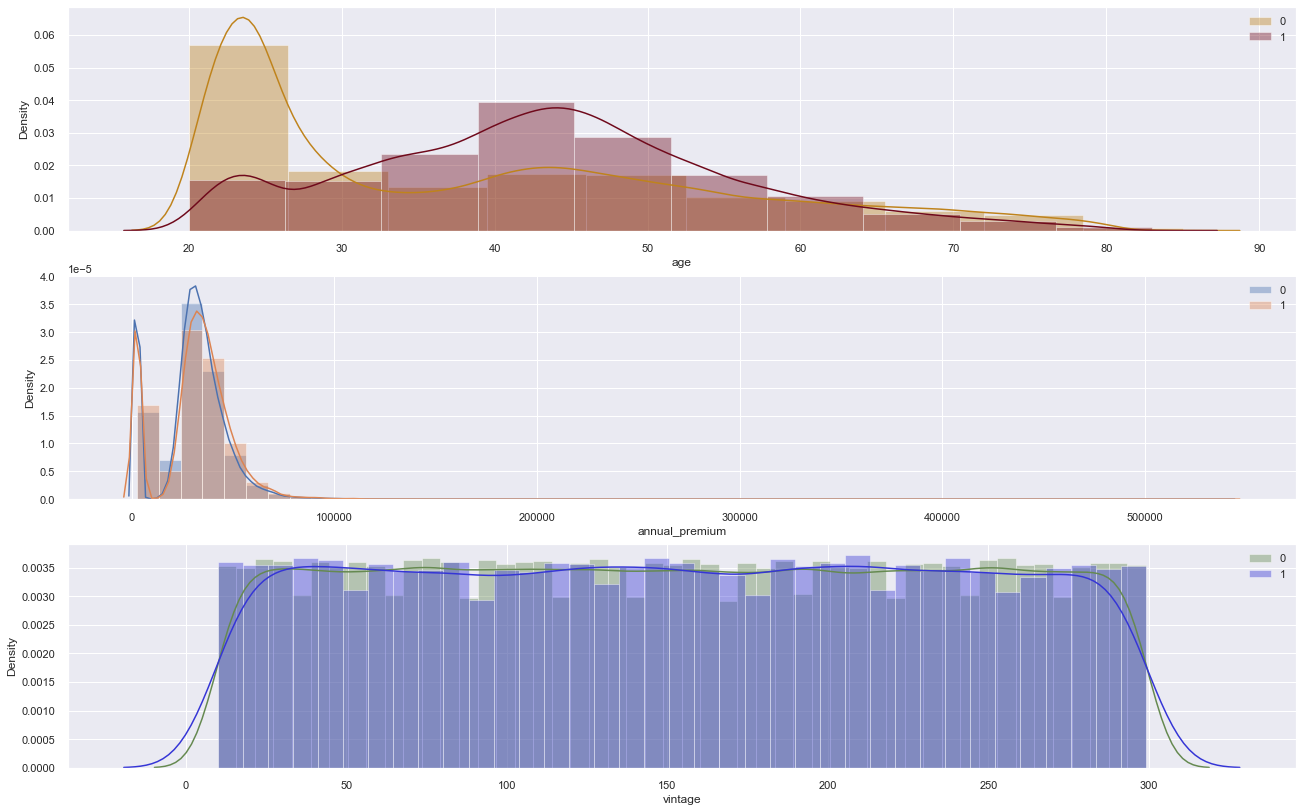

In [22]:
plt.figure(figsize=(22, 14))
plt.subplot(3, 1, 1)
sns.distplot(num_features.loc[num_features['response'] == 0, 'age'], bins=10, color='#bf831c', label=0)
sns.distplot(num_features.loc[num_features['response'] == 1, 'age'], bins=10, color='#6f091b', label=1)
plt.legend();

plt.subplot(3, 1, 2)
sns.distplot(num_features.loc[num_features['response'] == 0, 'annual_premium'], label=0)
sns.distplot(num_features.loc[num_features['response'] == 1, 'annual_premium'], label=1)
plt.legend();

plt.subplot(3, 1, 3)
sns.distplot(num_features.loc[num_features['response'] == 0, 'vintage'], color='#658950', label=0)
sns.distplot(num_features.loc[num_features['response'] == 1, 'vintage'], color='#3535D6', label=1)
plt.legend();

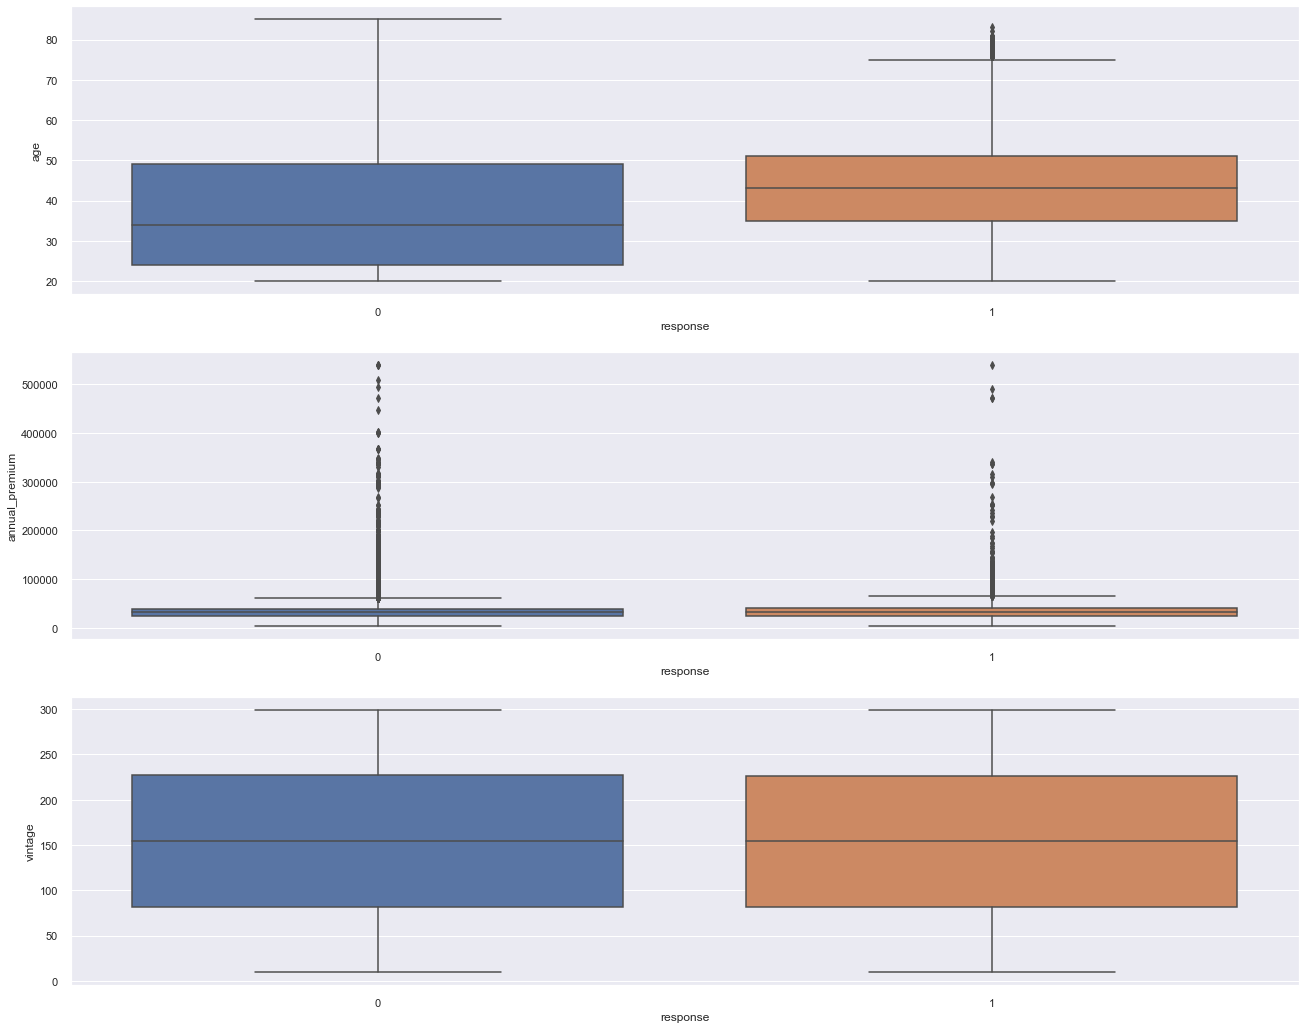

In [23]:
plt.figure(figsize=(22, 18))
plt.subplot(3, 1, 1)
sns.boxplot(x='response', y='age', data=num_features);

plt.subplot(3, 1, 2)
sns.boxplot(x='response', y='annual_premium', data=num_features);

plt.subplot(3, 1, 3)
sns.boxplot(x='response', y='vintage', data=num_features);

### Numerical Analysis Summary

No modification is needed in numerical attributes.

## Categorical Features

In [24]:
cat_features = df1_eda.select_dtypes(include=['object'])
cat_features.columns

Index(['gender', 'region_code', 'policy_sales_channel', 'driving_license',
       'vehicle_age', 'vehicle_damage', 'previously_insured', 'response'],
      dtype='object')

In [25]:
cat_features.describe()

,gender,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,response
count,381109,"381,109.00","381,109.00",381109,381109,381109,381109,381109
unique,2,53.00,155.00,2,3,2,2,2
top,Male,28.00,152.00,1,1-2 Year,Yes,0,0
freq,206089,"106,415.00","134,784.00",380297,200316,192413,206481,334399


**policy_sales**

- This variable is a complex categorical variable because it has too many categories. I will encode this variable and see if it is selected by the Random Forest or by the RFE.

**region_code**

- Same problem with variable "policy_sales". We will try same encoding strategy.

### Frequency Tables and Plots

In this section, I will validate or not the hypothesis raised in the "Business Understanding" section. This will be done in the next cycle. This first cycle I want make a full process in order to get a better understand of the business problem and about the dataset.

**Gender**

In [26]:
gender = cat_features['gender'].value_counts(normalize=True)
gender

Male     0.54
Female   0.46
Name: gender, dtype: float64

In [27]:
ct_gender_norm = pd.crosstab(cat_features['gender'], cat_features['response']).apply(lambda x: x/x.sum(), axis=1)
ct_gender_norm

response,0,1
gender,,
Female,0.90,0.10
Male,0.86,0.14


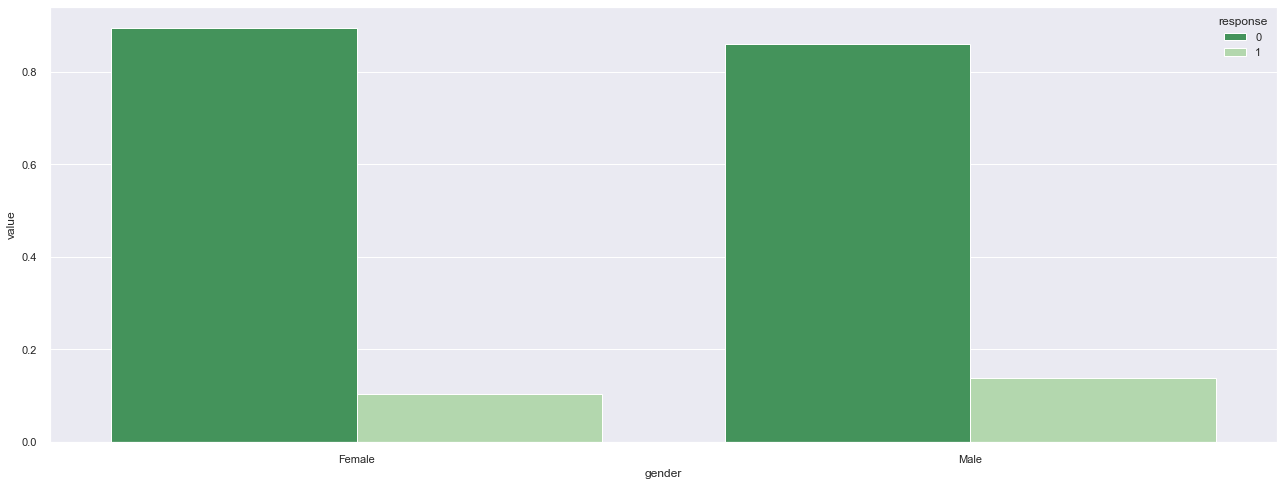

In [28]:
stacked_gender = ct_gender_norm.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked_gender.gender, y=stacked_gender.value, hue=stacked_gender.response, palette="Greens_r");

**Driving License**

In [29]:
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
driving_license = cat_features['driving_license'].value_counts(normalize=True)
driving_license

1   0.9979
0   0.0021
Name: driving_license, dtype: float64

In [30]:
ct_dl_norm = pd.crosstab(cat_features['driving_license'], cat_features['response']).apply(lambda x: x/x.sum(), axis=1)
ct_dl_norm

response,0,1
driving_license,,
0,0.9495,0.0505
1,0.8773,0.1227


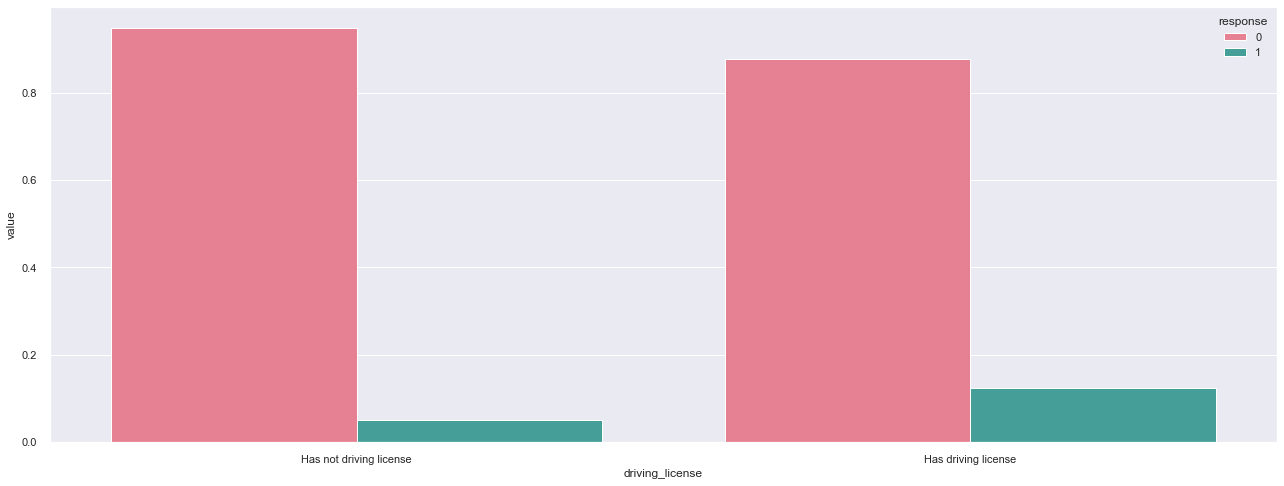

In [31]:
stacked_dl = ct_dl_norm.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked_dl.driving_license, y=stacked_dl.value, hue=stacked_dl.response, palette='husl')
plt.xticks([0, 1], ['Has not driving license', 'Has driving license']);

**Vehicle Age**

In [32]:
vehicle_age = cat_features['vehicle_age'].value_counts(normalize=True)
vehicle_age

1-2 Year    0.5256
< 1 Year    0.4324
> 2 Years   0.0420
Name: vehicle_age, dtype: float64

In [33]:
ct_va_norm = pd.crosstab(cat_features['vehicle_age'], cat_features['response']).apply(lambda x: x/x.sum(), axis=1)
ct_va_norm

response,0,1
vehicle_age,,
1-2 Year,0.8262,0.1738
< 1 Year,0.9563,0.0437
> 2 Years,0.7063,0.2937


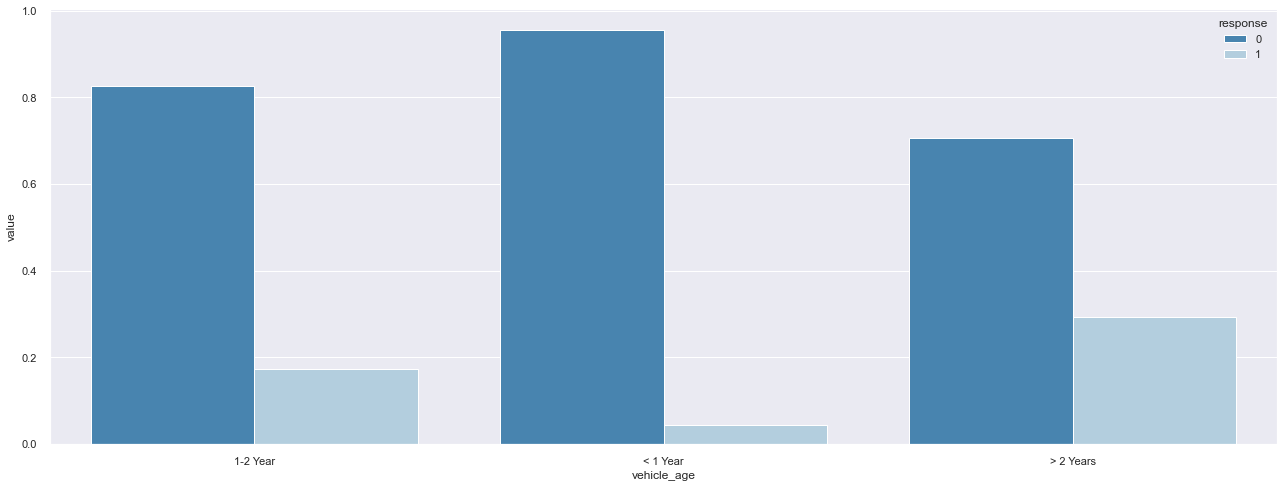

In [34]:
stacked_va = ct_va_norm.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked_va.vehicle_age, y=stacked_va.value, hue=stacked_va.response, palette='Blues_r');

**Vehicle Damage**

In [35]:
vehicle_damage = cat_features['vehicle_damage'].value_counts(normalize=True)
vehicle_damage

Yes   0.5049
No    0.4951
Name: vehicle_damage, dtype: float64

In [36]:
ct_vd_norm = pd.crosstab(cat_features['vehicle_damage'], cat_features['response']).apply(lambda x: x/x.sum(), axis=1)
ct_vd_norm

response,0,1
vehicle_damage,,
No,0.9948,0.0052
Yes,0.7623,0.2377


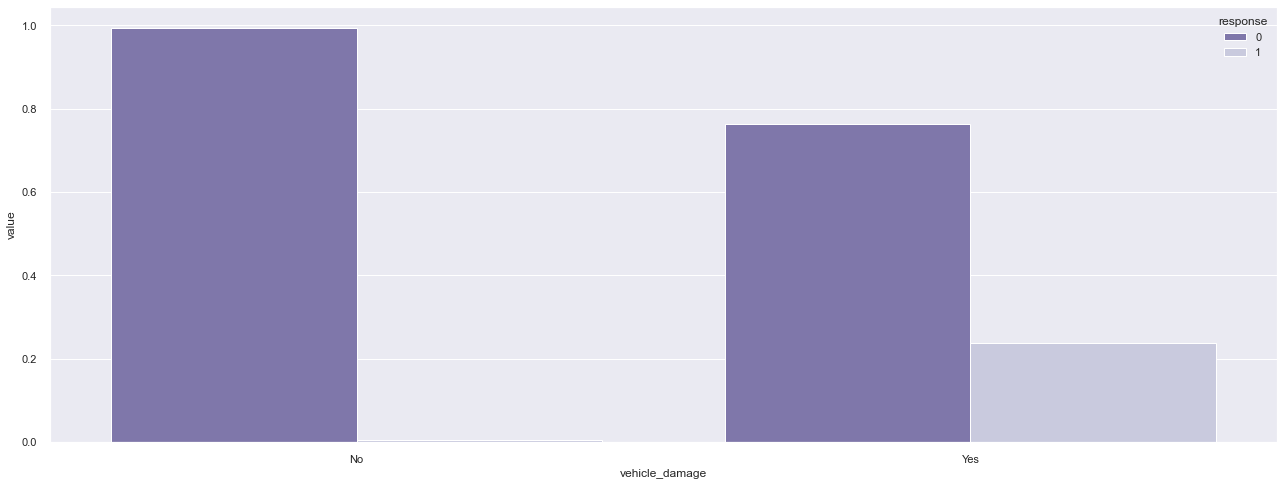

In [37]:
stacked_vd = ct_vd_norm.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked_vd.vehicle_damage, y=stacked_vd.value, hue=stacked_vd.response, palette='Purples_r');

**Previously Insured**

In [38]:
previously_insured = cat_features['previously_insured'].value_counts(normalize=True)
previously_insured

0   0.5418
1   0.4582
Name: previously_insured, dtype: float64

In [39]:
ct_pi_norm = pd.crosstab(cat_features['previously_insured'], cat_features['response']).apply(lambda x: x/x.sum(), axis=1)
ct_pi_norm

response,0,1
previously_insured,,
0,0.7745,0.2255
1,0.9991,0.0009


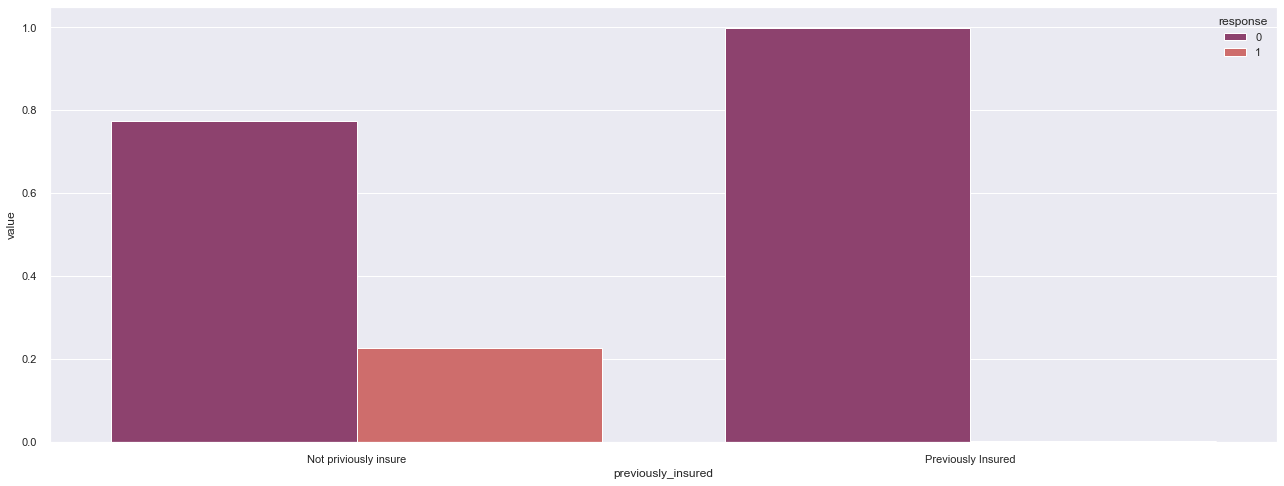

In [40]:
stacked_pi = ct_pi_norm.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked_pi.previously_insured, y=stacked_pi.value, hue=stacked_pi.response, palette="flare_r")
plt.xticks([0, 1], ['Not priviously insure', 'Previously Insured']);

**Region Code**

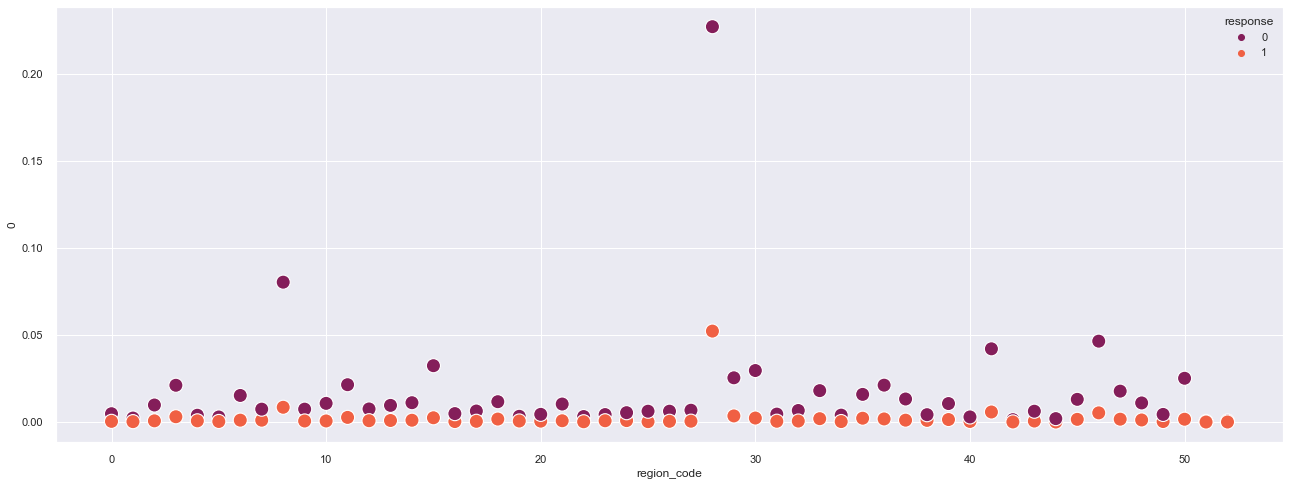

In [41]:
region_response = cat_features[['region_code', 'response']].value_counts(normalize=True).reset_index().sort_values('region_code')
sns.scatterplot(x='region_code', y=0, data=region_response, hue='response', s=200, palette='rocket');

**Policy Salles Channel**

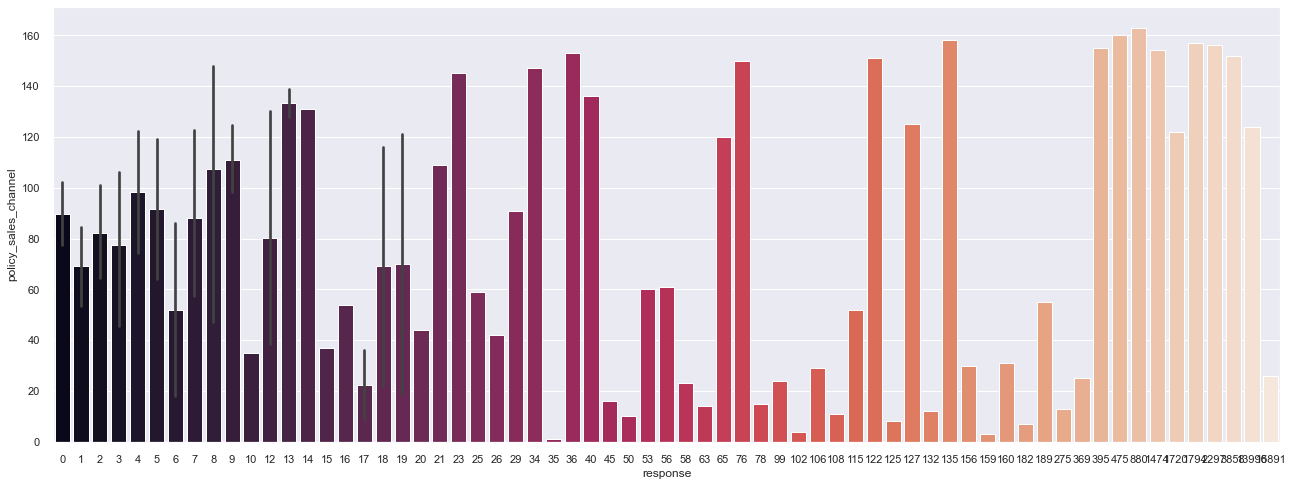

In [42]:
policy_response = cat_features[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=policy_response, palette='rocket');

### Categorical Analysis Summary

In this first cycle, all categorical variables will be kept in the dataset.

## Correlations

### Numerical

This function show all pairs of varibles which are correlated above a threshold.

In [43]:
df_num_corr = correlation_verifier(num_features, threshold=0.50, numerical=True)

Theres is no strong correlation in this dataset.


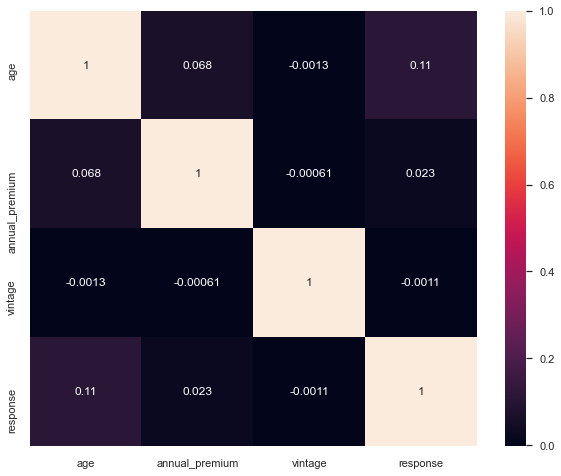

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(num_features.corr(), annot=True);

* None of the numerical variables is highly correlated with one another.

### Categorical

In [45]:
df_cat_corr = correlation_verifier(cat_features, threshold=0.50, numerical=False)

                     policy_sales_channel vehicle_age vehicle_damage previously_insured
vehicle_age                        0.6226          --             --                 --
policy_sales_channel                   --      0.6226             --                 --
previously_insured                     --          --         0.8241                 --
vehicle_damage                         --          --             --             0.8241


* Policy_sales_channel is a complex categoric variable with a lot of categories. As it is highly correlated with vehicle_age, it could be eliminated from the dataset. However, in this iteration of the process, I won't eliminate any variable in the "EDA" section.

* We also see that vehicle_damage is highly correlated with previously_insured. Maybe one of them can also be eliminated in future iterations of the process.

## Variables Removed

In this first iteration of the process, no feature was rejected in the exploratory analysis.

# Feature Engineering

In this first iteration of the process, I will think about some new features, but they won't be used yet. This process of thinking about new variables is also an exercise that help to understand the variables and their relationships.

In [46]:
df1_fe = df1_eda.copy()

## Create New Features

**Premium per Day**

This variable shows how much a customer spend per day with premium, since his/her is already a customer. Maybe customer with high premium per day has a felling that he is spend too much with insurance and will not accept the new proposal.

In [47]:
# annual_premium / vintage (how much a person spend in premium per day since his is a customer)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

df1_fe['premium_per_day'] = df1_fe['annual_premium'] / df1_fe['vintage']

**Premium per Age**

This variable shows a rate of payment per year of age. Younger people with high premium problably will not accept the new proposal because they tend have a lower income. Younger people will have lower rate.

In [48]:
# annual_premium / age (how much a customer spend in premium per years old he/she is.)
df1_fe['premium_per_age'] = df1_fe['annual_premium'] / df1_fe['age']

**Premium per Region Mean, Premium per Region Std, Qtd People by Region**

These variables shows a rate of premium per region (mean and standard deviation), and the number of people per region.

In [49]:
premium_by_region_mean = df1_fe.groupby('region_code')['annual_premium'].mean()
premium_by_region_std = df1_fe.groupby('region_code')['annual_premium'].std()
qtd_people_by_region = df1_fe.groupby('region_code')['annual_premium'].count()

In [50]:
df1_fe['premium_by_region_mean'] = df1_fe['region_code'].apply(lambda x: premium_by_region_mean[x])
df1_fe['premium_by_region_std'] = df1_fe['region_code'].apply(lambda x: premium_by_region_std[x])
df1_fe['qtd_people_by_region'] = df1_fe['region_code'].apply(lambda x: qtd_people_by_region[x])

**Premium per People by Region**

This variable shows the mean premium per region divided by the number of people in that region.

In [51]:
# the rate qtd_people_by_region / premium_by_region_mean
df1_fe['premium_people_by_region'] = df1_fe['premium_by_region_mean'] / df1_fe['qtd_people_by_region']

## Exploratory Analysis for New Features

In [52]:
new_features = ['premium_per_day', 'premium_per_age', 'premium_by_region_mean', 'premium_by_region_std', 
                'qtd_people_by_region', 'premium_people_by_region']

In [53]:
num_stats(df1_fe[new_features])

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,premium_per_day,8.80,"33,717.29","33,708.49",363.74,194.75,548.65,5.74,107.71
1,premium_per_age,30.94,"21,456.45","21,425.51",905.99,870.10,601.01,1.73,22.71
2,premium_by_region_mean,"2,693.84","38,668.87","35,975.03","30,564.39","29,624.52","7,385.27",-1.34,3.65
3,premium_by_region_std,"1,488.04","24,479.32","22,991.28","15,144.44","14,902.66","3,524.57",-1.31,3.54
4,qtd_people_by_region,183.00,"106,415.00","106,232.00","38,159.99","13,308.00","43,297.19",0.87,-1.11
5,premium_people_by_region,0.36,153.08,152.71,3.42,2.09,6.02,12.69,264.12


### Distributions

**premium per day**

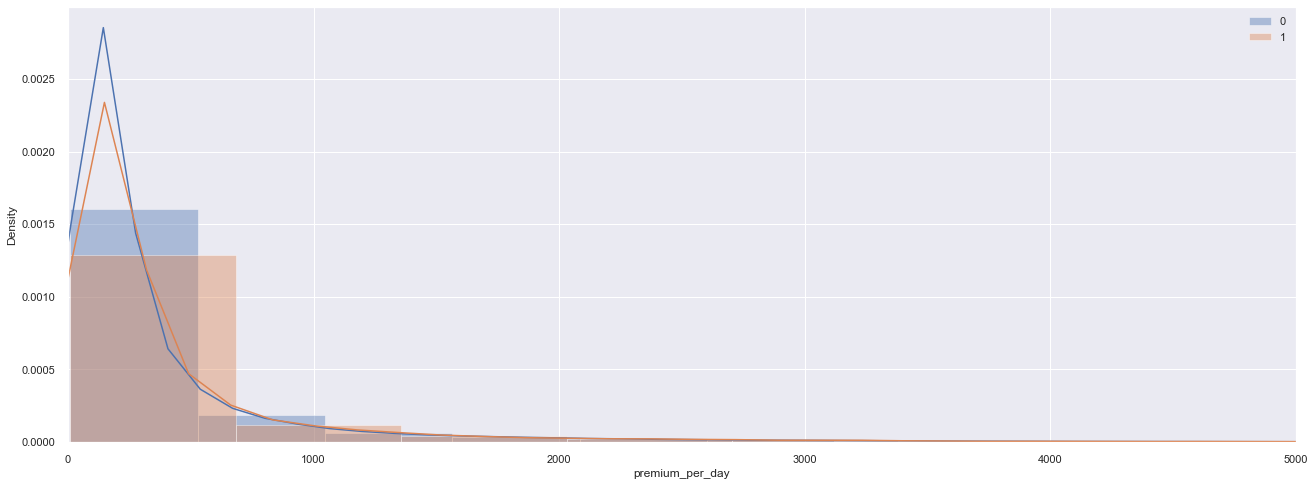

In [54]:
sns.distplot(df1_fe.loc[df1_fe['response'] == 0, 'premium_per_day'], label=0)
sns.distplot(df1_fe.loc[df1_fe['response'] == 1, 'premium_per_day'], label=1)
plt.xlim(0, 5000)
plt.legend();

**premium per age**

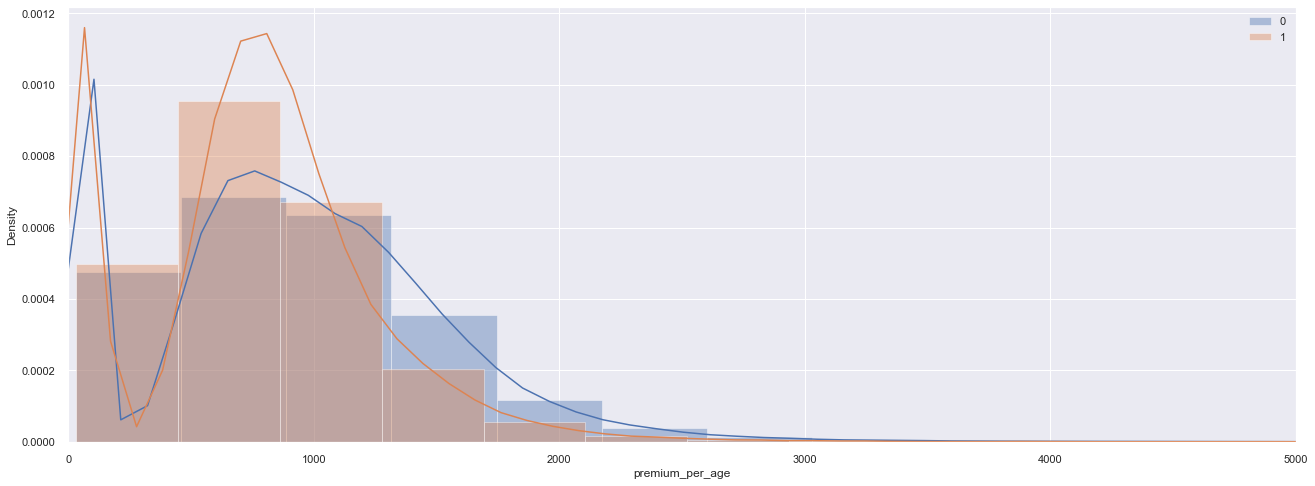

In [55]:
sns.distplot(df1_fe.loc[df1_fe['response'] == 0, 'premium_per_age'], label=0)
sns.distplot(df1_fe.loc[df1_fe['response'] == 1, 'premium_per_age'], label=1)
plt.xlim(0, 5000)
plt.legend();

**premium_by_region_mean**

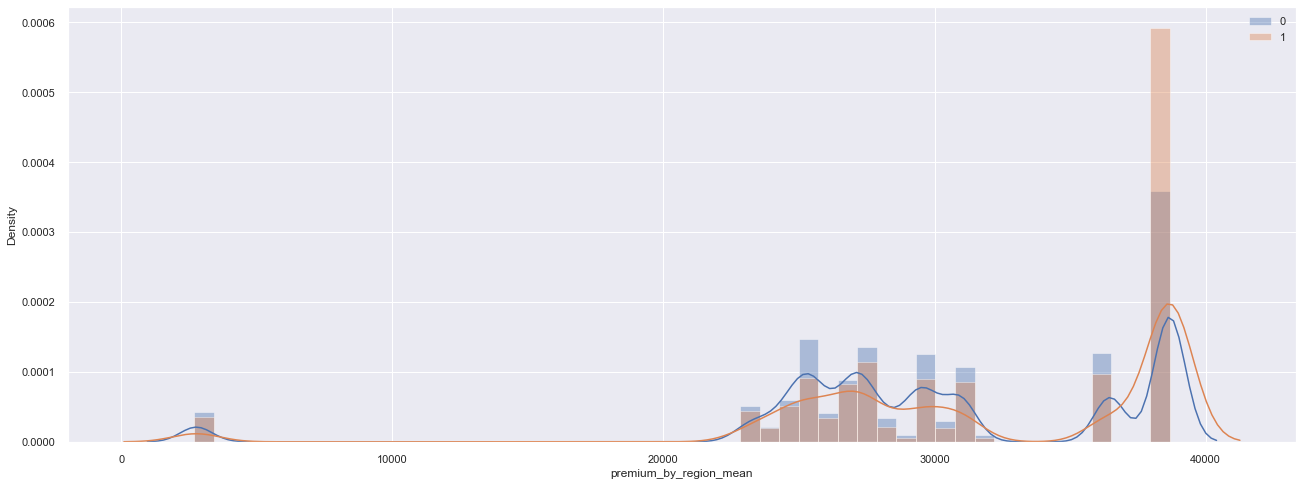

In [56]:
sns.distplot(df1_fe.loc[df1_fe['response'] == 0, 'premium_by_region_mean'], label=0)
sns.distplot(df1_fe.loc[df1_fe['response'] == 1, 'premium_by_region_mean'], label=1)
plt.legend();

**premium_by_region_std**

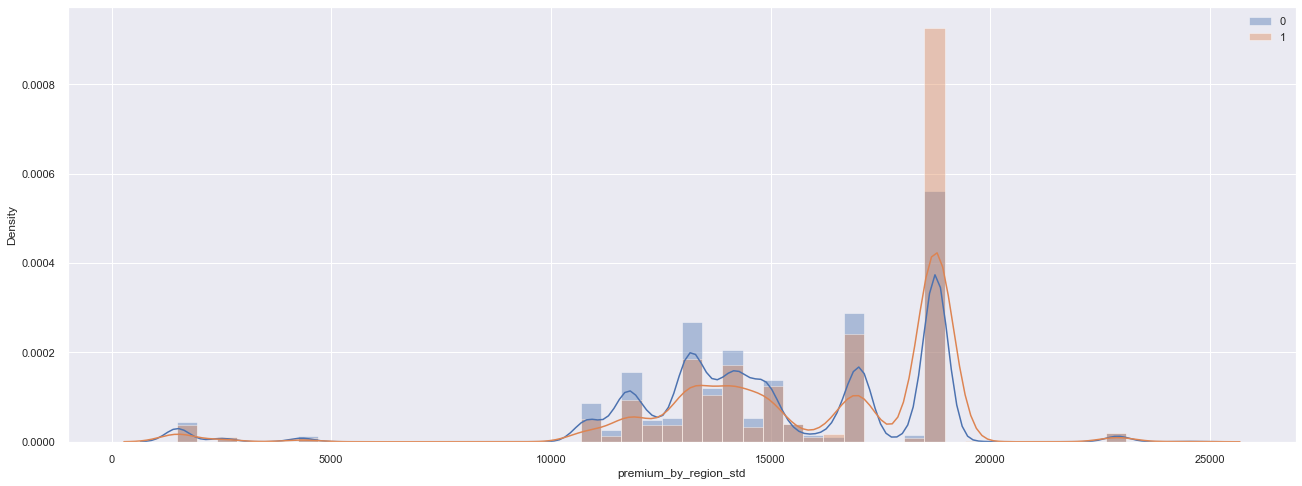

In [57]:
sns.distplot(df1_fe.loc[df1_fe['response'] == 0, 'premium_by_region_std'], label=0)
sns.distplot(df1_fe.loc[df1_fe['response'] == 1, 'premium_by_region_std'], label=1)
plt.legend();

**qtd_people_by_region**

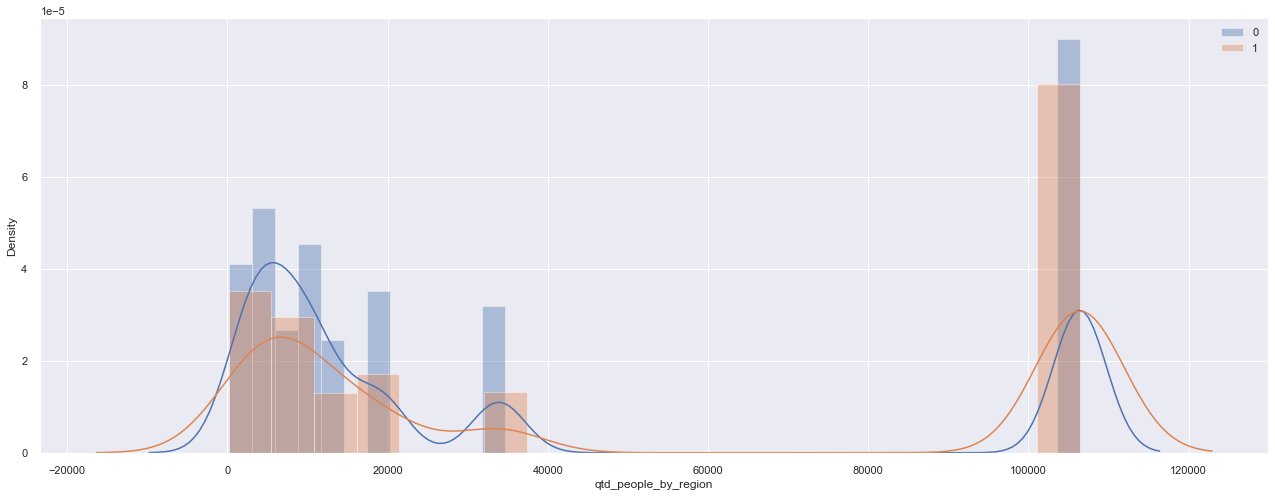

In [58]:
sns.distplot(df1_fe.loc[df1_fe['response'] == 0, 'qtd_people_by_region'], label=0)
sns.distplot(df1_fe.loc[df1_fe['response'] == 1, 'qtd_people_by_region'], label=1)
plt.legend();

**premium_people_by_region**

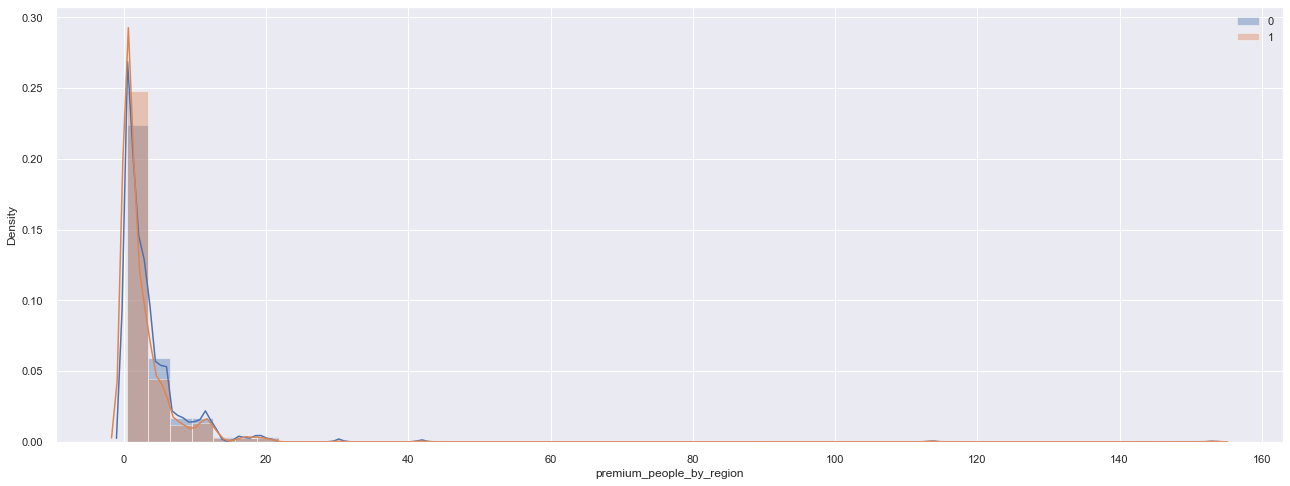

In [59]:
sns.distplot(df1_fe.loc[df1_fe['response'] == 0, 'premium_people_by_region'], label=0)
sns.distplot(df1_fe.loc[df1_fe['response'] == 1, 'premium_people_by_region'], label=1)
plt.legend();

The interesting point here is to observe the difference in behavior between the distributions when separated by the classes of the target variable. Variables useful in explaining the phenomenon under study generally have different behavior between those distributions. In this case, it seems that the behaviors between those distributions is pretty similar, indicating that they are probably not useful variables. Let's see later on what the feature selection with Random Forest and RFE has to tell us about that.

### Correlations Between New Features

In [60]:
df_news_corr = correlation_verifier(df1_fe[new_features], threshold=0.50, numerical=True)

                       premium_by_region_mean premium_by_region_std qtd_people_by_region
premium_by_region_std                     0.9                    --                   --
qtd_people_by_region                     0.76                    --                   --
premium_by_region_mean                     --                   0.9                   --
qtd_people_by_region                       --                  0.69                   --
premium_by_region_mean                     --                    --                 0.76
premium_by_region_std                      --                    --                 0.69


The three variables showed above in the table (premium_by_region_mean, qtd_people_by_region and premium_by_region_std) are highly correlated with one another. Besides that, the distributions shows that the new features doesn't have great potential to explain the phenomenon under study.

## Variables Removed

As I said before, I will not eliminate any variable from the dataset in this first iteration of the process.

# Variable Filtering (by business restrictions)

## Filtering Rows

Filtering rows is not needed in this case.

## Filtering Columns

There is no restriction about the variables in this dataset.

# Hypothesis Summary

### Final Hypothesis

I didn't evaluate hypothesis in this cycle.

# <font color='red'>3. Data Preparation</font>

I am going to rescale and encode only original variables from the dataset. As the new variables from the "Feature Engineering" won't be used in this first iteration, they won't receive any kind of preparation.

# Transformations

I am going to split the dataset at this point because in order to rescale the data, we need to do it with training and test set separately. Also, the next section, I will balance the dataset and only the training set should be balanced.

In [61]:
df2 = df1_eda.copy()

In [62]:
X = df2.drop('response', axis=1)
y = df2['response'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, stratify=y, random_state=42)
print('y_train response variable:', np.bincount(y_train))
print('y_test response variable:', np.bincount(y_test))

y_train response variable: [234079  32697]
y_test response variable: [100320  14013]


## Rescaling

In [63]:
age_mms = MinMaxScaler()
annual_premium_mms = MinMaxScaler()
vintage_mms = MinMaxScaler()

# age
X_train['age'] = age_mms.fit_transform(X_train[['age']].values)

# annual_premium
X_train['annual_premium'] = annual_premium_mms.fit_transform(X_train[['annual_premium']].values)

# vintage
X_train['vintage'] = vintage_mms.fit_transform(X_train[['vintage']].values)

In [64]:
# Rescaling X_test

# age
X_test['age'] = age_mms.transform(X_test[['age']].values)

# annual_premium
X_test['annual_premium'] = annual_premium_mms.transform(X_test[['annual_premium']].values)

# vintage
X_test['vintage'] = vintage_mms.transform(X_test[['vintage']].values)

## Encoding

In [65]:
X_train = pd.concat((X_train, y_train), axis=1)

# Gender
X_train['gender'] = X_train['gender'].map({'Female': 0.8, 'Male': 0.2})

# region_code
target_encoding_region_code = X_train.groupby('region_code')['response'].mean()
X_train.loc[:, 'region_code'] = X_train['region_code'].map(target_encoding_region_code)

# policy_sales_channel
fe_policy_sales_channel = X_train.groupby('policy_sales_channel').size()/len(X_train)
X_train.loc[:, 'policy_sales_channel'] = X_train['policy_sales_channel'].map(fe_policy_sales_channel)

# driving_license
X_train['driving_license'] = X_train['driving_license'].astype(int)

# previously_insured - Already as 0 and 1
X_train['previously_insured'] = X_train['previously_insured'].astype(int)

# Vehicle_damage
mapping = {'No': 0, 'Yes': 1}
X_train['vehicle_damage'] = X_train['vehicle_damage'].map(lambda x: mapping.get(x,x))

# vehicle_age - OneHotEncoding / Order Encoding / Frequency Encoding
X_train['vehicle_age'] = X_train['vehicle_age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

X_train = X_train.drop('response', axis=1)

In [66]:
X_test = pd.concat((X_test, y_test), axis=1)

# Encoding X_test
# Gender
X_test['gender'] = X_test['gender'].map({'Female': 0, 'Male': 1})

# region_code
target_encoding_region_code = X_test.groupby('region_code')['response'].mean()
X_test.loc[:, 'region_code'] = X_test['region_code'].map(target_encoding_region_code)

# policy_sales_channel
fe_policy_sales_channel = X_test.groupby('policy_sales_channel').size()/len(X_test)
X_test.loc[:, 'policy_sales_channel'] = X_test['policy_sales_channel'].map(fe_policy_sales_channel)

# driving_license
X_test['driving_license'] = X_test['driving_license'].astype(int)

# previously_insured - Already as 0 and 1
X_test['previously_insured'] = X_test['previously_insured'].astype(int)

# Vehicle_damage
mapping = {'No': 0, 'Yes': 1}
X_test['vehicle_damage'] = X_test['vehicle_damage'].map(lambda x: mapping.get(x,x))

# vehicle_age - OneHotEncoding / Order Encoding / Frequency Encoding
X_test['vehicle_age'] = X_test['vehicle_age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

X_test = X_test.drop('response', axis=1)

# Balancing Dataset

As I said before, only the training set should and will be balanced. I used 3 different techniques to balance the dataset: Random Undersampling, Random Oversampling and SMOTE + Tomek Link. 

## Random Undersampling

In [67]:
# Define sampler
us = under_sampling.RandomUnderSampler(sampling_strategy='majority')

# apply sampler
X_under, y_under = us.fit_resample(X_train, y_train)

In [68]:
y_under.value_counts()

0    32697
1    32697
Name: response, dtype: int64

## Random Oversampling

In [69]:
# Define sampler
os = over_sampling.RandomOverSampler(sampling_strategy='minority')

# Apply sampler
X_over, y_over = os.fit_resample(X_train, y_train)

In [70]:
y_over.value_counts()

0    234079
1    234079
Name: response, dtype: int64

## SMOTE + Tomek Link

In [71]:
# Define sampler
smt = combine.SMOTETomek(sampling_strategy='auto', n_jobs=-1)

# Apply sampler
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [72]:
y_smt.value_counts()

0    229695
1    229695
Name: response, dtype: int64

In this iteration, I decided to select the SMOTE + Tomek Link results to apply the Machine Learning models.

# Feature Selection

For feature selection, I selected 2 techniques: Random Forest, with the feature_importances_ function, and Recursive Feature Elimination (RFE). Let's see the results!

## Random Forest as Feature Selector

In [73]:
X_train_fs = X_smt.copy()
y_train_fs = y_smt.copy()

In [74]:
rf_selector = RandomForestClassifier(max_depth=10, n_jobs=-1)
rf_selector.fit(X_train_fs, y_train_fs)
rf_selector.feature_importances_

array([0.00181007, 0.10505805, 0.03515247, 0.10259116, 0.0004894 ,
       0.03222651, 0.38571822, 0.31954675, 0.01380775, 0.0035996 ])

In [75]:
df = pd.DataFrame()
for i, j in zip(X_train_fs, rf_selector.feature_importances_):
    aux = pd.DataFrame({'Feature': i, 'Importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
df.sort_values('Importance', ascending=False)

,Feature,Importance
0,vehicle_damage,0.39
0,previously_insured,0.32
0,age,0.11
0,policy_sales_channel,0.10
0,region_code,0.04
0,vehicle_age,0.03
0,annual_premium,0.01
0,vintage,0.00
0,gender,0.00
0,driving_license,0.00


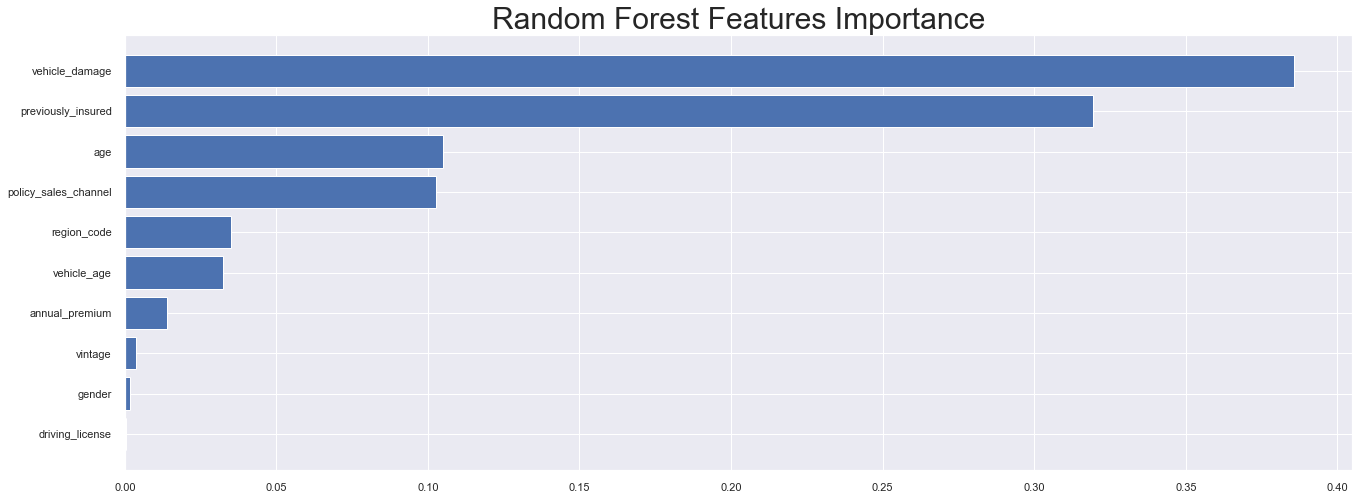

In [76]:
sorted_features = rf_selector.feature_importances_.argsort()

plt.barh(X_train_fs.columns[sorted_features], rf_selector.feature_importances_[sorted_features])
plt.title('Random Forest Features Importance', fontsize=30);

In [77]:
cols_selected_rf = ['previously_insured', 'vehicle_damage', 'policy_sales_channel', 
                    'age', 'vehicle_age', 'region_code']

I decided to select the features that showed an importance level above 0.04. So, for Random Forest Feature Importance, we end up with 6 features selected. They are:
* previously_insured
* vehicle_damage
* policy_sales_channel
* age
* vehicle_age
* region_code

## RFE

In [78]:
rf_rfe = RandomForestClassifier(max_depth=10, n_jobs=-1)

selector = RFE(rf_rfe, n_features_to_select=6, step=1)
selector = selector.fit(X_train_fs, y_train_fs)

In [79]:
 X_train_fs.columns[selector.support_]

Index(['age', 'region_code', 'policy_sales_channel', 'vehicle_age',
       'vehicle_damage', 'previously_insured'],
      dtype='object')

In [80]:
df = pd.DataFrame()
for i, j in zip(X_train_fs, selector.support_):
    aux = pd.DataFrame({'Feature': i, 'Accepted': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
df.sort_values('Accepted', ascending=False)

,Feature,Accepted
0,age,True
0,region_code,True
0,policy_sales_channel,True
0,vehicle_age,True
0,vehicle_damage,True
0,previously_insured,True
0,gender,False
0,driving_license,False
0,annual_premium,False
0,vintage,False


In [81]:
cols_selected_rfe = ['age', 'region_code', 'policy_sales_channel', 'vehicle_age', 'vehicle_damage',
       'previously_insured']

The RFE also selected 6 features. They are:
* age
* region_code
* policy_sales_channel
* vehicle_age
* vehicle_damage
* previously_insured

The variables are the same selected by the Random Forest Feature Importances.

# <font color='red'>4. Modeling</font>

# Machine Learning Models

## Preparing and Spliting Dataset

The dataset needs to be prepared in order to train the models. What we have until now:

* These two datasets are the original X and y training sets, from the split made before. They will be used to train the models without balancing:
    * X_train
    * y_train

* These two datasets are the original X and y test sets, from the first split. They were not balanced and will be splited into validation (65%) and test (35%) datasets, for future assessment of the performance of the models:
    * X_test
    * y_test

* These two datasets are the balanced datasets obtained from X_train and y_train, via SMOTE+Tomek. 
they will be used to train the models with balancing:
    * X_smt
    * y_smt

Besides that, all the above datasets need to be prepared in order to have only the columns selected in the "Feature Selection" step. As both techniques reached the same results, we can use any of them.

In [82]:
# Making copies of the datasets
X_train_1 = X_train[cols_selected_rf].copy()
y_train_1 = y_train.copy()

X_test_1 = X_test[cols_selected_rf].copy()
y_test_1 = y_test.copy()

X_smt_1 = X_smt[cols_selected_rf].copy()
y_smt_1 = y_smt.copy()

In [83]:
X_train_imb = X_train_1
y_train_imb = y_train_1.copy()

X_train_bal = X_smt_1
y_train_bal = y_smt_1.copy()

In [84]:
# Spliting the dataset into training and test sets.
X_val, X_test, y_val, y_test = train_test_split(X_test_1, y_test_1, test_size=0.35, stratify=y_test_1)

In [85]:
# Test dataset to assess models with precision_at_k function
df3_val = pd.concat([X_val, y_val], axis=1)

In [86]:
print(np.bincount(y_train_imb))
print(np.bincount(y_train_bal))
print(np.bincount(y_val))
print(np.bincount(y_test))

[234079  32697]
[229695 229695]
[65208  9108]
[35112  4905]


## Logistic regression

In [87]:
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=3000, verbose=0, n_jobs=-1)

### Imbalanced Logistic Regression

In [88]:
lr_metrics_imb, lr_predict_imb, lr_yval_imb = cross_validation(lr, X_train_imb, y_train_imb, num_fold=5, at_k=20000)
lr_metrics_imb

Cross-Validation -> Fold: 1/5 - Precision: 0.2818 / Recall: 0.8618
Cross-Validation -> Fold: 2/5 - Precision: 0.2801 / Recall: 0.8569
Cross-Validation -> Fold: 3/5 - Precision: 0.2809 / Recall: 0.8593
Cross-Validation -> Fold: 4/5 - Precision: 0.2796 / Recall: 0.8552
Cross-Validation -> Fold: 5/5 - Precision: 0.2818 / Recall: 0.8618


{'precision': 0.2808459577021149, 'recall': 0.8589777168557695}

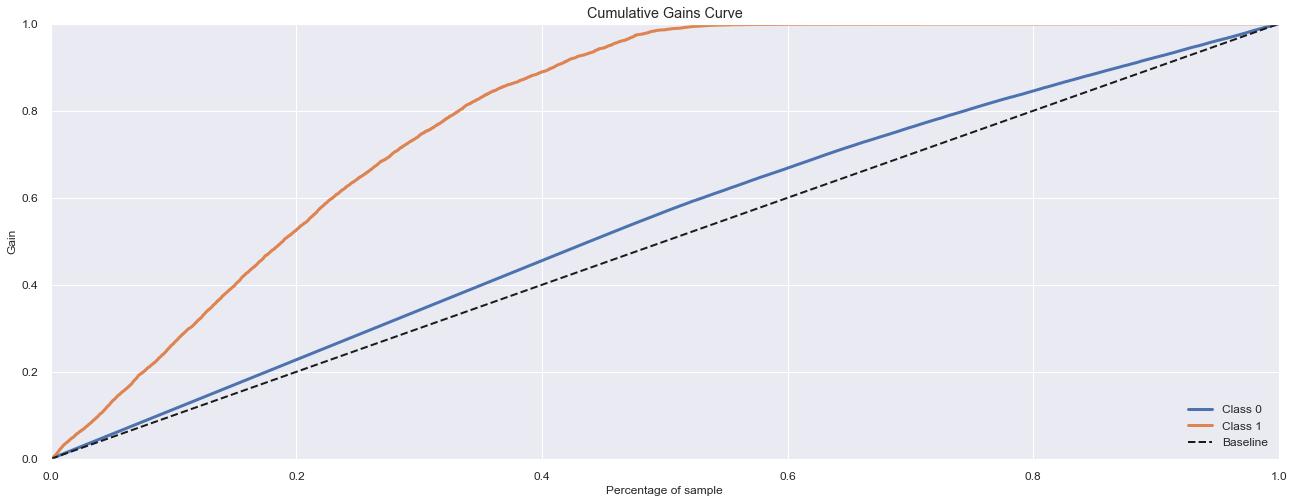

In [89]:
skplt.metrics.plot_cumulative_gain(lr_yval_imb, lr_predict_imb);

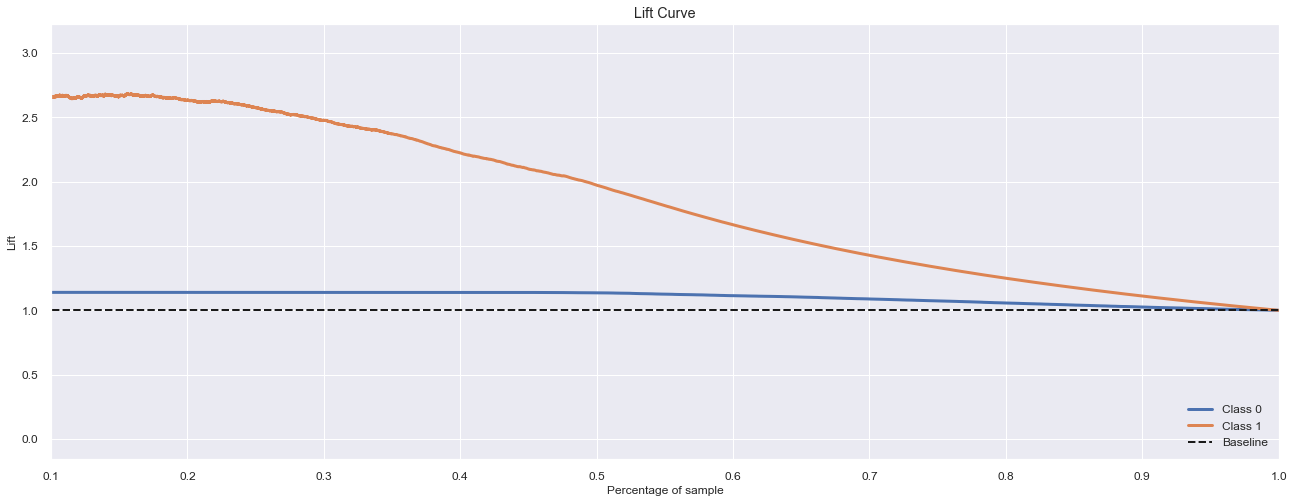

In [90]:
skplt.metrics.plot_lift_curve(lr_yval_imb, lr_predict_imb)
plt.xlim(0.10, 1.0);

#### Validation Set

In [91]:
lr_val_imb = LogisticRegression(class_weight='balanced', random_state=42, 
                                max_iter=3000, verbose=0, n_jobs=-1).fit(X_train_imb, y_train_imb)

In [92]:
lr_predict_imb_val = lr_val_imb.predict_proba(X_val) 

In [93]:
lr_precision_imb, _ = precision_at_k(df3_val, lr_predict_imb_val, k=20000)
lr_precision_imb

0.30583470826458675

In [94]:
lr_recall_imb, _ = recall_at_k(df3_val, lr_predict_imb_val, k=20000)
lr_recall_imb

0.6716073781291173

### Balanced Logistic Regression

In [95]:
lr_metrics_bal, lr_predict_bal, lr_yval_bal = cross_validation(lr, X_train_bal, y_train_bal, num_fold=5, at_k=20000)
lr_metrics_bal

Cross-Validation -> Fold: 1/5 - Precision: 0.7812 / Recall: 0.3401
Cross-Validation -> Fold: 2/5 - Precision: 0.7856 / Recall: 0.342
Cross-Validation -> Fold: 3/5 - Precision: 0.7833 / Recall: 0.341
Cross-Validation -> Fold: 4/5 - Precision: 0.7812 / Recall: 0.3401
Cross-Validation -> Fold: 5/5 - Precision: 0.787 / Recall: 0.3427


{'precision': 0.783650817459127, 'recall': 0.3411872265395416}

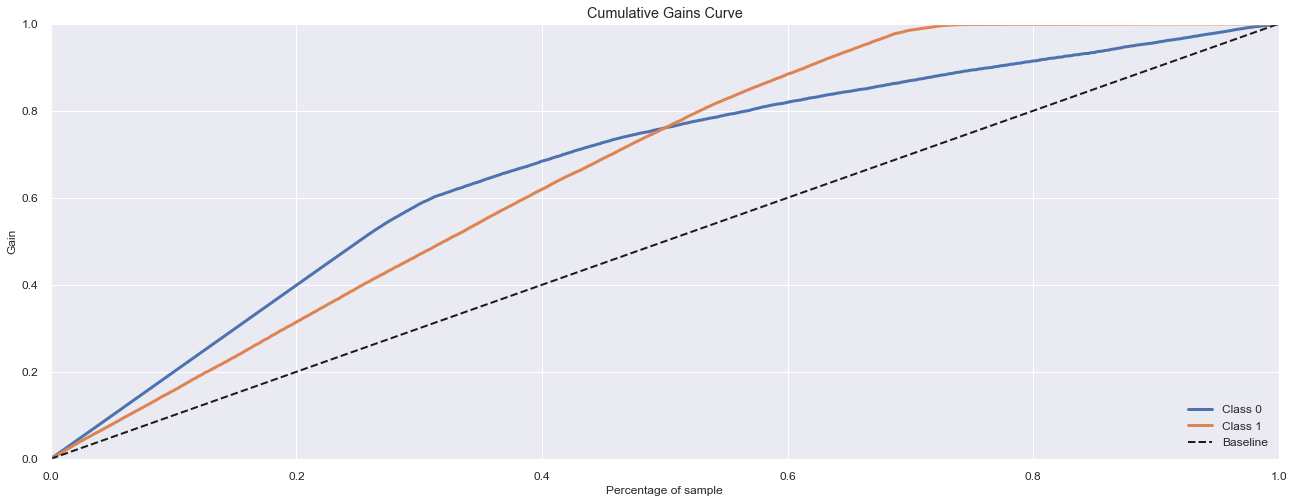

In [96]:
skplt.metrics.plot_cumulative_gain(lr_yval_bal, lr_predict_bal);

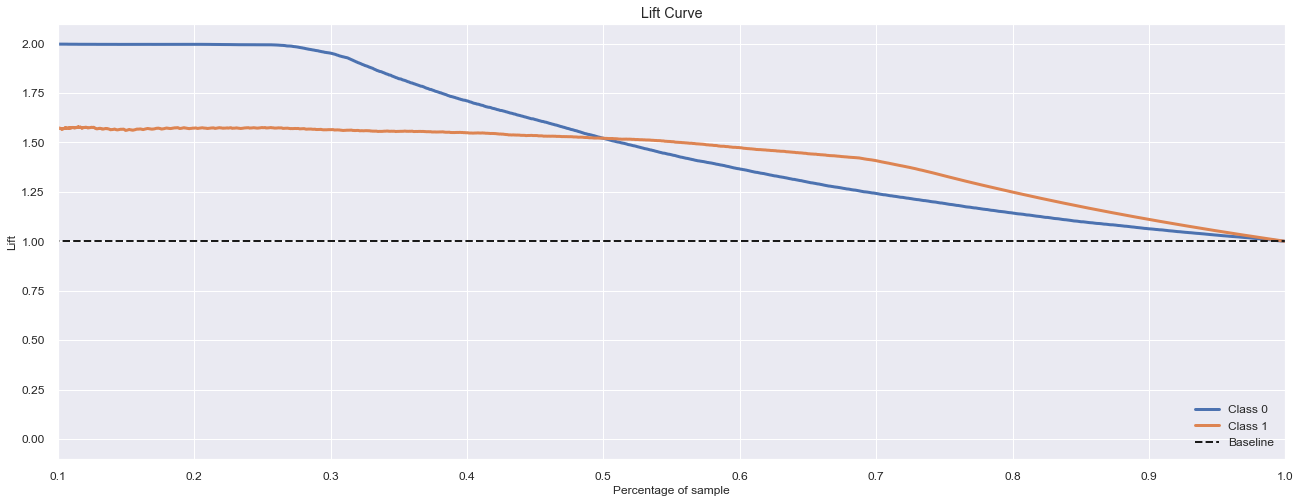

In [97]:
skplt.metrics.plot_lift_curve(lr_yval_bal, lr_predict_bal)
plt.xlim(0.1, 1.0);

#### Validation Set

In [98]:
lr_val_bal = LogisticRegression(class_weight='balanced', random_state=42, 
                        max_iter=3000, verbose=0, n_jobs=-1).fit(X_train_bal, y_train_bal)

In [99]:
lr_predict_bal_val = lr_val_bal.predict_proba(X_val) 

In [100]:
lr_precision_bal, data_precision = precision_at_k(df3_val, lr_predict_bal_val, k=20000)
lr_precision_bal

0.3050847457627119

In [101]:
lr_recall_bal, data_recall = recall_at_k(df3_val, lr_predict_bal_val, k=20000)
lr_recall_bal

0.6699604743083004

## Random Forest

In [102]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbose=0, class_weight='balanced')

### Imbalance Random Forest

In [103]:
rf_metrics_imb, rf_predict_imb, rf_yval_imb = cross_validation(rf, X_train_imb, y_train_imb, num_fold=5, at_k=20000)
rf_metrics_imb

Cross-Validation -> Fold: 1/5 - Precision: 0.2665 / Recall: 0.8151
Cross-Validation -> Fold: 2/5 - Precision: 0.2675 / Recall: 0.8183
Cross-Validation -> Fold: 3/5 - Precision: 0.2687 / Recall: 0.8218
Cross-Validation -> Fold: 4/5 - Precision: 0.267 / Recall: 0.8166
Cross-Validation -> Fold: 5/5 - Precision: 0.2682 / Recall: 0.8202


{'precision': 0.26758662066896655, 'recall': 0.8184237552805959}

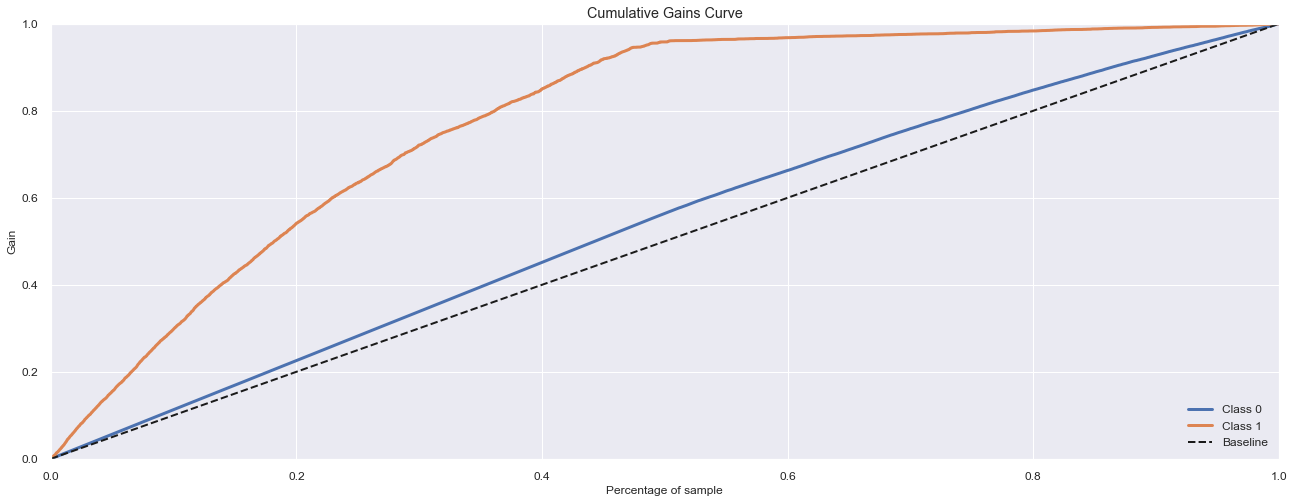

In [104]:
skplt.metrics.plot_cumulative_gain(rf_yval_imb, rf_predict_imb);

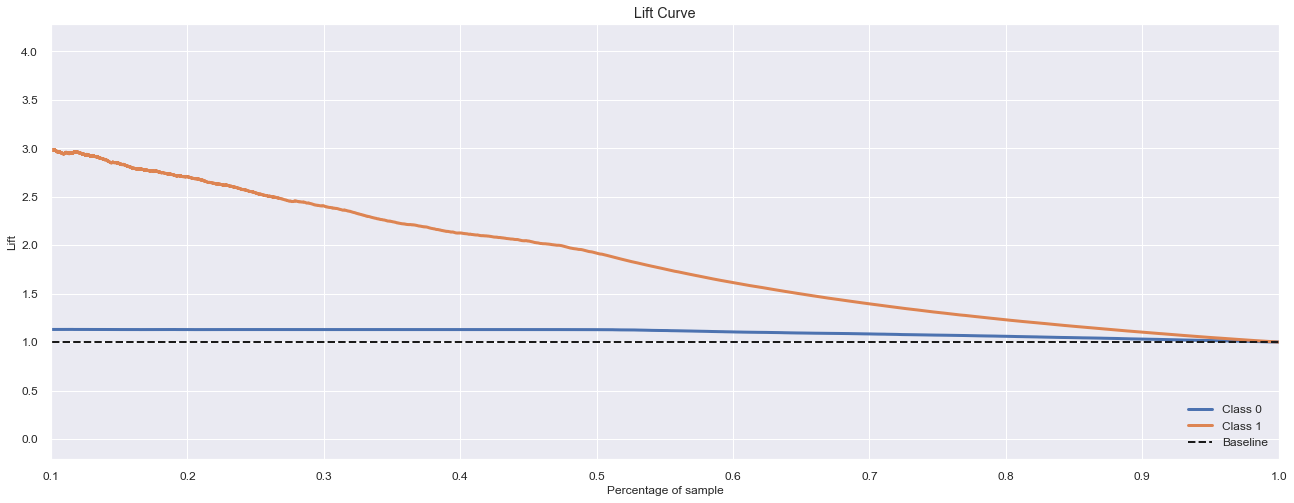

In [105]:
skplt.metrics.plot_lift_curve(rf_yval_imb, rf_predict_imb)
plt.xlim(0.1, 1.0);

#### Validation Set

In [106]:
rf_val_imb = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
                                    verbose=0, class_weight='balanced').fit(X_train_imb, y_train_imb)

In [107]:
rf_predict_imb_val = rf_val_imb.predict_proba(X_val) 

In [108]:
rf_precision_imb, _ = precision_at_k(df3_val, rf_predict_imb_val, k=20000)
rf_precision_imb

0.2974351282435878

In [109]:
rf_recall_imb, _ = recall_at_k(df3_val, rf_predict_imb_val, k=20000)
rf_recall_imb

0.6531620553359684

### Balanced Random Forest

In [110]:
rf_metrics_bal, rf_predict_bal, rf_yval_bal = cross_validation(rf, X_train_bal, y_train_bal, num_fold=5, at_k=20000)
rf_metrics_bal

Cross-Validation -> Fold: 1/5 - Precision: 0.9994 / Recall: 0.4351
Cross-Validation -> Fold: 2/5 - Precision: 0.9991 / Recall: 0.435
Cross-Validation -> Fold: 3/5 - Precision: 0.9994 / Recall: 0.4351
Cross-Validation -> Fold: 4/5 - Precision: 0.9993 / Recall: 0.4351
Cross-Validation -> Fold: 5/5 - Precision: 0.9994 / Recall: 0.4351


{'precision': 0.99930003499825, 'recall': 0.4350769498683036}

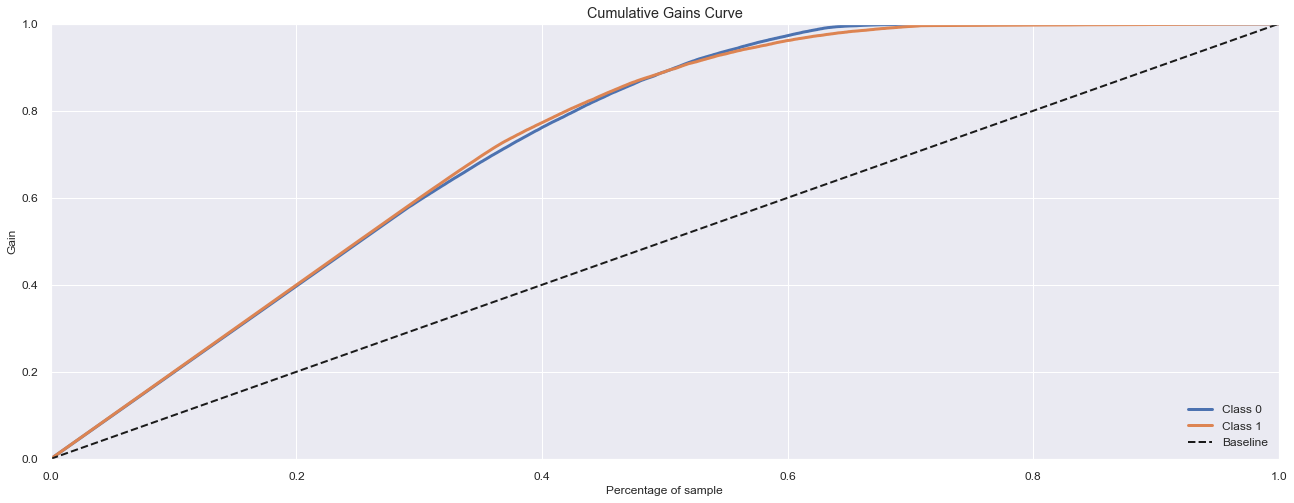

In [111]:
skplt.metrics.plot_cumulative_gain(rf_yval_bal, rf_predict_bal);

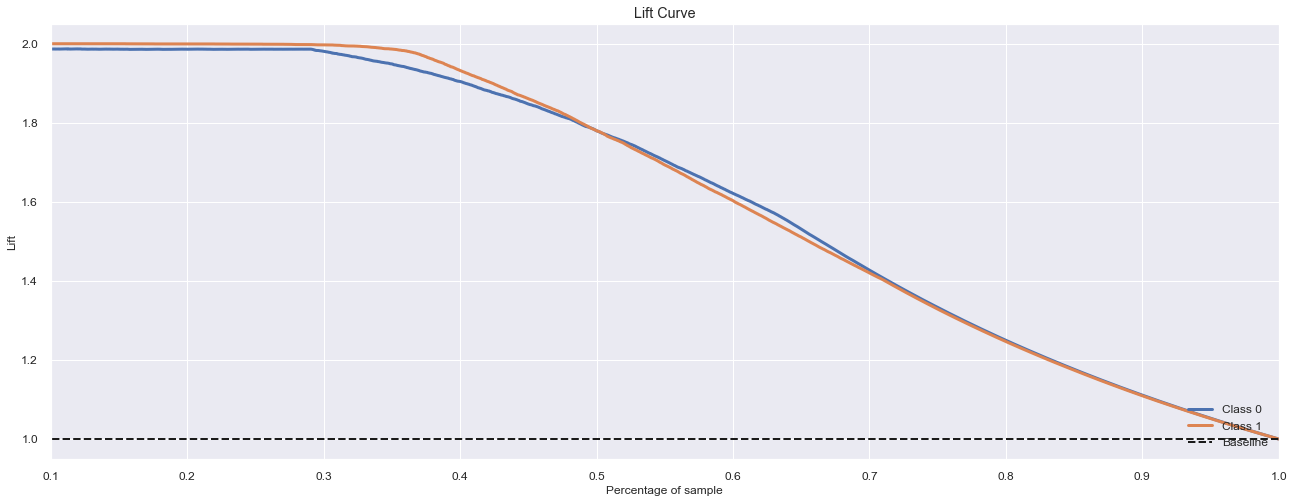

In [112]:
skplt.metrics.plot_lift_curve(rf_yval_bal, rf_predict_bal)
plt.xlim(0.1, 1.0);

#### Validation Set

In [113]:
rf_val_bal = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
                                    verbose=0, class_weight='balanced').fit(X_train_bal, y_train_bal)

In [114]:
rf_predict_bal_val = rf_val_bal.predict_proba(X_val) 

In [115]:
rf_precision_bal, _ = precision_at_k(df3_val, rf_predict_bal_val, k=20000)
rf_precision_bal

0.27468626568671567

In [116]:
rf_recall_bal, _ = recall_at_k(df3_val, rf_predict_bal_val, k=20000)
rf_recall_bal

0.6032059727711901

## XGBoost

In [117]:
xgb = XGBClassifier(eval_metric='logloss', n_jobs=-1, random_state=42)

### Imbalanced XGBoost

In [118]:
xgb_metrics_imb, xgb_predict_imb, xgb_yval_imb = cross_validation(xgb, X_train_imb, y_train_imb, num_fold=5, at_k=20000)
xgb_metrics_imb

Cross-Validation -> Fold: 1/5 - Precision: 0.2942 / Recall: 0.8998
Cross-Validation -> Fold: 2/5 - Precision: 0.2939 / Recall: 0.8991
Cross-Validation -> Fold: 3/5 - Precision: 0.2912 / Recall: 0.8908
Cross-Validation -> Fold: 4/5 - Precision: 0.2913 / Recall: 0.891
Cross-Validation -> Fold: 5/5 - Precision: 0.2949 / Recall: 0.902


{'precision': 0.29312534373281335, 'recall': 0.8965345822033222}

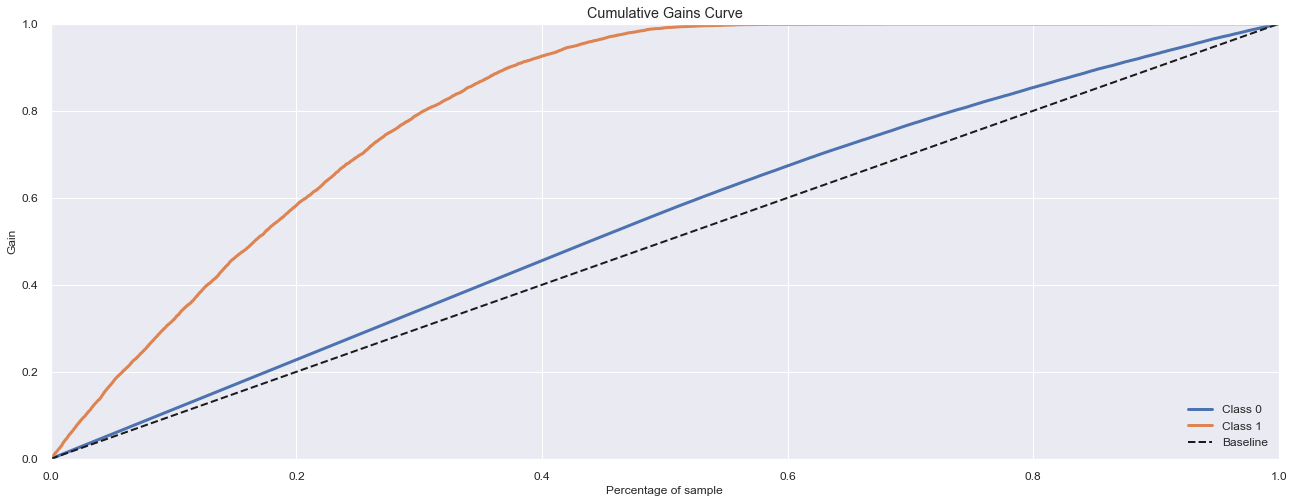

In [119]:
skplt.metrics.plot_cumulative_gain(xgb_yval_imb, xgb_predict_imb);

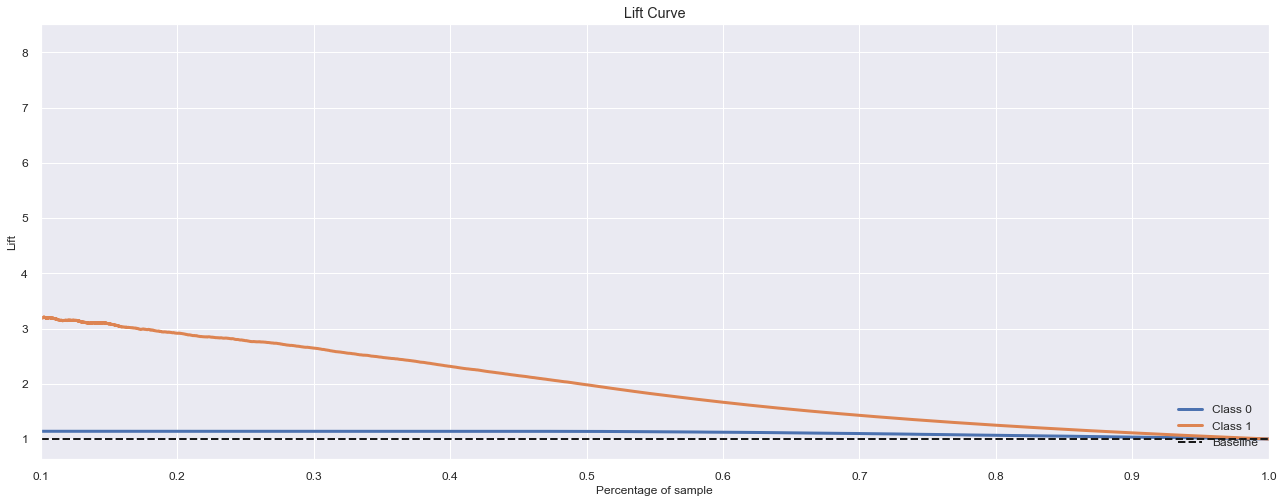

In [120]:
skplt.metrics.plot_lift_curve(xgb_yval_imb, xgb_predict_imb)
plt.xlim(0.1, 1.0);

#### Validation Set

In [121]:
xgb_val_imb = XGBClassifier(eval_metric='logloss', n_jobs=-1, random_state=42).fit(X_train_imb, y_train_imb)

In [122]:
xgb_predict_imb_val = xgb_val_imb.predict_proba(X_val) 

In [123]:
xgb_precision_imb, _ = precision_at_k(df3_val, xgb_predict_imb_val, k=20000)
xgb_precision_imb

0.32373381330933454

In [124]:
xgb_recall_imb, _ = recall_at_k(df3_val, xgb_predict_imb_val, k=20000)
xgb_recall_imb

0.7109134826526131

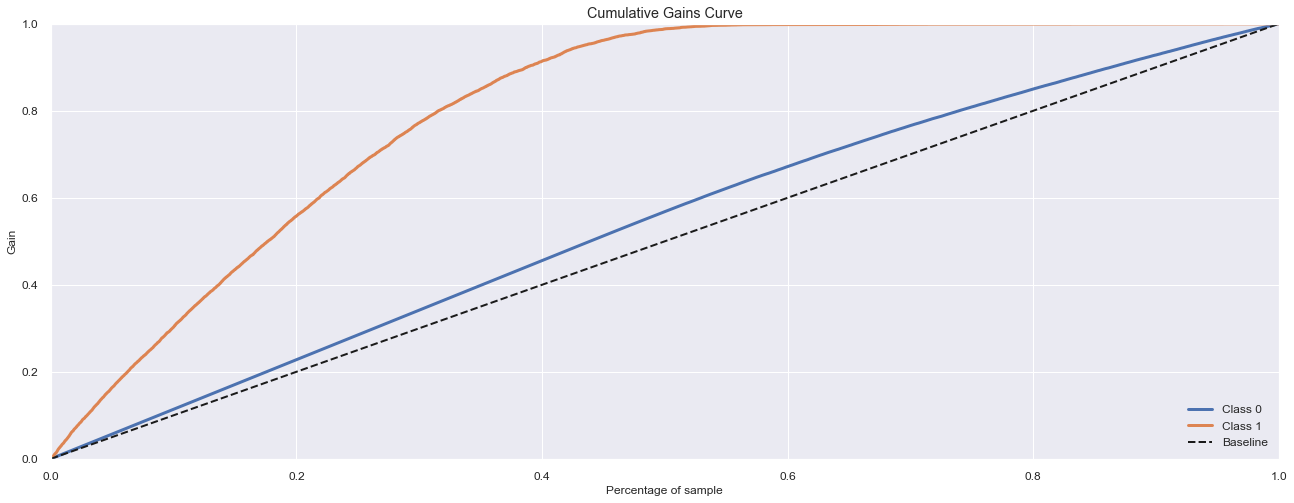

In [125]:
skplt.metrics.plot_cumulative_gain(y_val, xgb_predict_imb_val);

### Balanced XGBoost

In [126]:
xgb_metrics_bal, xgb_predict_bal, xgb_yval_bal = cross_validation(xgb, X_train_bal, y_train_bal, num_fold=5, at_k=20000)
xgb_metrics_bal

Cross-Validation -> Fold: 1/5 - Precision: 1.0 / Recall: 0.4354
Cross-Validation -> Fold: 2/5 - Precision: 1.0 / Recall: 0.4354
Cross-Validation -> Fold: 3/5 - Precision: 1.0 / Recall: 0.4354
Cross-Validation -> Fold: 4/5 - Precision: 1.0 / Recall: 0.4354
Cross-Validation -> Fold: 5/5 - Precision: 1.0 / Recall: 0.4354


{'precision': 1.0, 'recall': 0.4353817018219813}

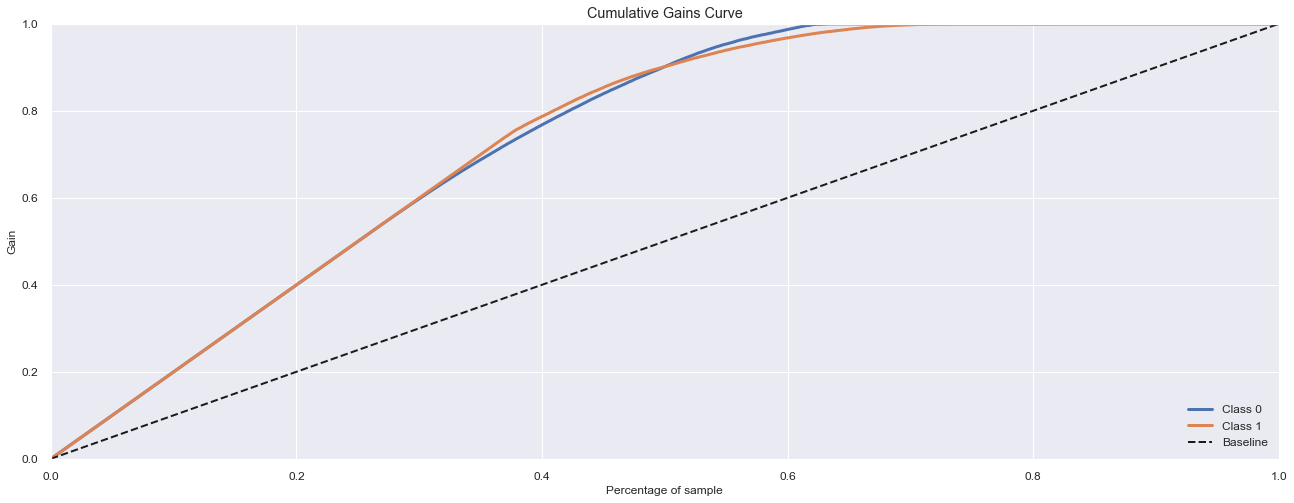

In [127]:
skplt.metrics.plot_cumulative_gain(xgb_yval_bal, xgb_predict_bal);

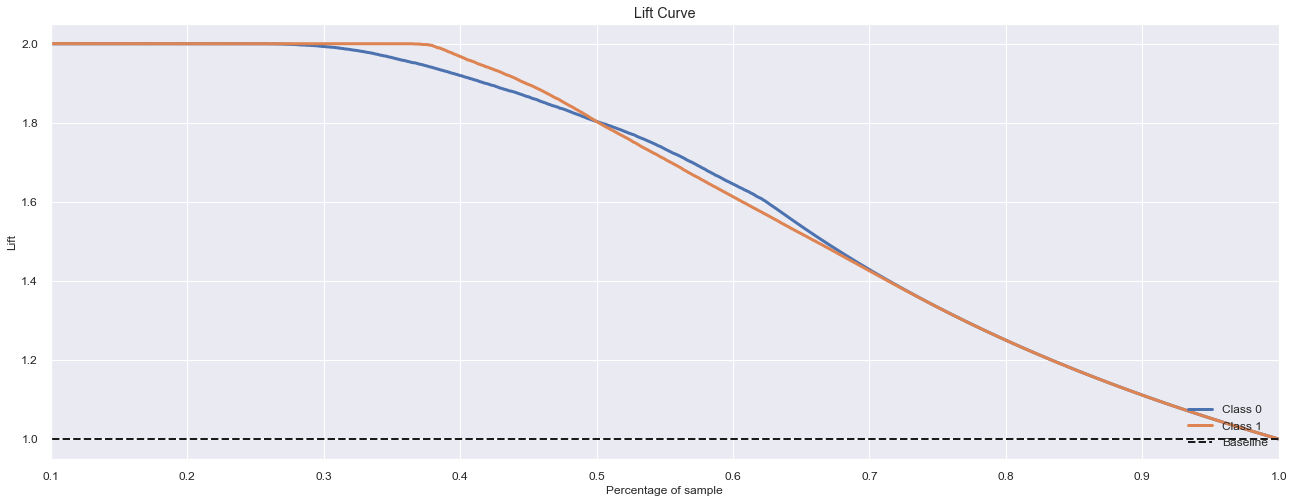

In [128]:
skplt.metrics.plot_lift_curve(xgb_yval_bal, xgb_predict_bal)
plt.xlim(0.1, 1.0);

#### Validation Set

In [129]:
xgb_val_bal = XGBClassifier(eval_metric='logloss', n_jobs=-1, random_state=42).fit(X_train_bal, y_train_bal)

In [130]:
xgb_predict_bal_val = xgb_val_bal.predict_proba(X_val)

In [131]:
xgb_precision_bal, _ = precision_at_k(df3_val, xgb_predict_bal_val, k=20000)
xgb_precision_bal

0.20953952302384882

In [132]:
xgb_recall_bal, _ = recall_at_k(df3_val, xgb_predict_bal_val, k=20000)
xgb_recall_bal

0.4601449275362319

## Extra Trees

In [133]:
xtree = ExtraTreesClassifier(n_estimators=40, n_jobs=-1, random_state=42, verbose=0, class_weight='balanced')

### Imbalanced Extra Trees

In [134]:
xtree_metrics_imb, xtree_predict_imb, xtree_yval_imb = cross_validation(xtree, X_train_imb, y_train_imb, num_fold=5, at_k=20000)
xtree_metrics_imb

Cross-Validation -> Fold: 1/5 - Precision: 0.266 / Recall: 0.8135
Cross-Validation -> Fold: 2/5 - Precision: 0.267 / Recall: 0.8168
Cross-Validation -> Fold: 3/5 - Precision: 0.2671 / Recall: 0.8171
Cross-Validation -> Fold: 4/5 - Precision: 0.2665 / Recall: 0.8153
Cross-Validation -> Fold: 5/5 - Precision: 0.2664 / Recall: 0.8148


{'precision': 0.26662666866656665, 'recall': 0.8154877416283293}

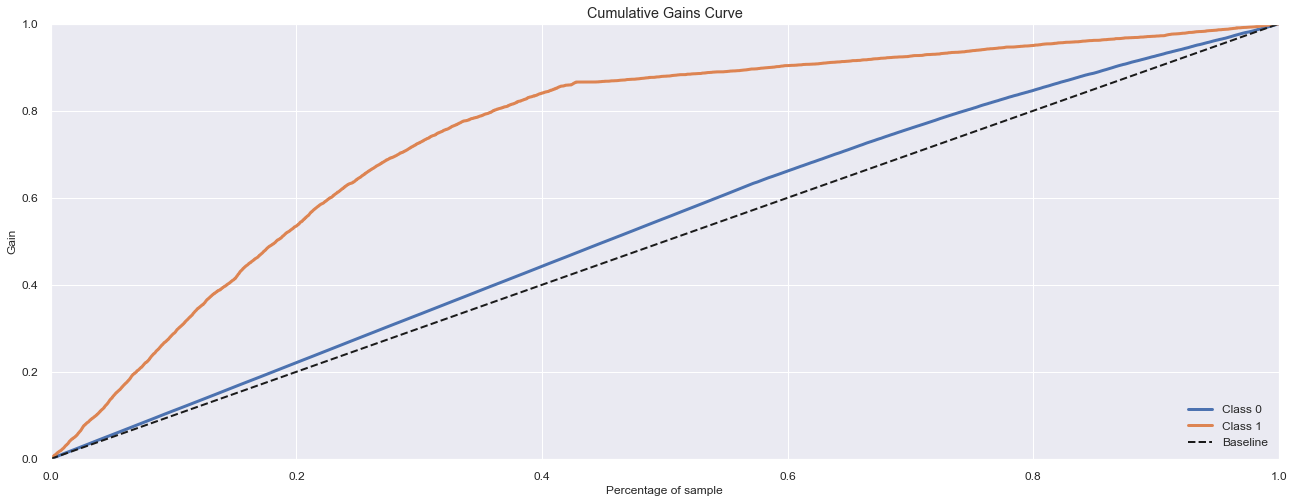

In [135]:
skplt.metrics.plot_cumulative_gain(xtree_yval_imb, xtree_predict_imb);

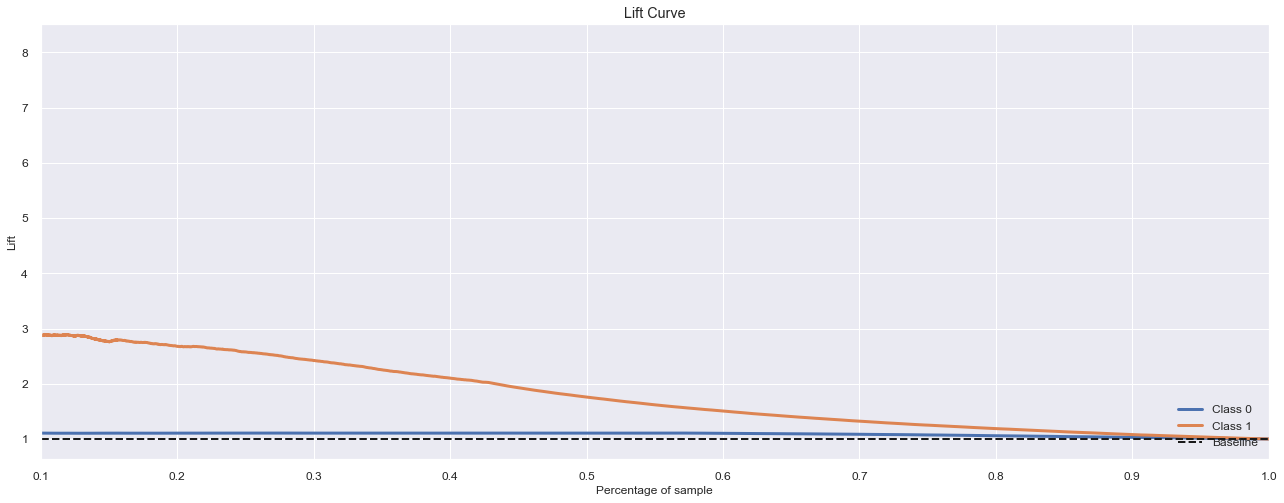

In [136]:
skplt.metrics.plot_lift_curve(xtree_yval_imb, xtree_predict_imb)
plt.xlim(0.1, 1.0);

#### Validation Set

In [137]:
xtree_val_imb = ExtraTreesClassifier(n_estimators=40, n_jobs=-1, random_state=42, 
                             verbose=0, class_weight='balanced').fit(X_train_imb, y_train_imb)

In [138]:
xtree_predict_imb_val = xtree_val_imb.predict_proba(X_val)

In [139]:
xtree_precision_imb, _ = precision_at_k(df3_val, xtree_predict_imb_val, k=20000)
xtree_precision_imb

0.29973501324933755

In [140]:
xtree_recall_imb, _ = recall_at_k(df3_val, xtree_predict_imb_val, k=20000)
xtree_recall_imb

0.6582125603864735

### Balanced Extras Trees

In [141]:
xtree_metrics_bal, xtree_predict_bal, xtree_yval_bal = cross_validation(xtree, X_train_bal, y_train_bal, num_fold=5, at_k=20000)
xtree_metrics_bal

Cross-Validation -> Fold: 1/5 - Precision: 0.9827 / Recall: 0.4278
Cross-Validation -> Fold: 2/5 - Precision: 0.9825 / Recall: 0.4278
Cross-Validation -> Fold: 3/5 - Precision: 0.9836 / Recall: 0.4282
Cross-Validation -> Fold: 4/5 - Precision: 0.9831 / Recall: 0.428
Cross-Validation -> Fold: 5/5 - Precision: 0.9845 / Recall: 0.4286


{'precision': 0.9832508374581271, 'recall': 0.4280894229304077}

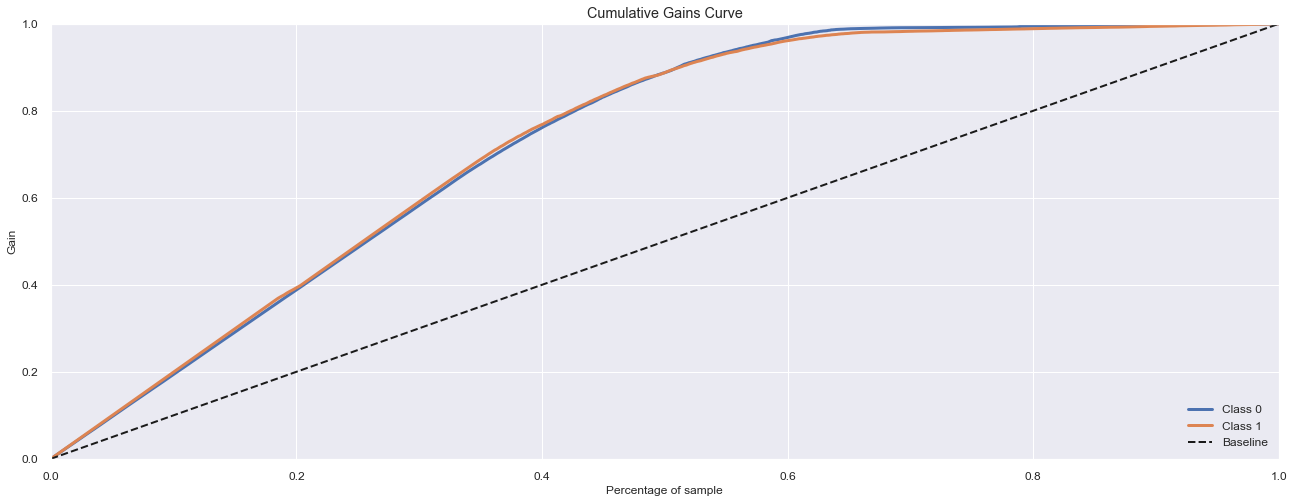

In [142]:
skplt.metrics.plot_cumulative_gain(xtree_yval_bal, xtree_predict_bal);

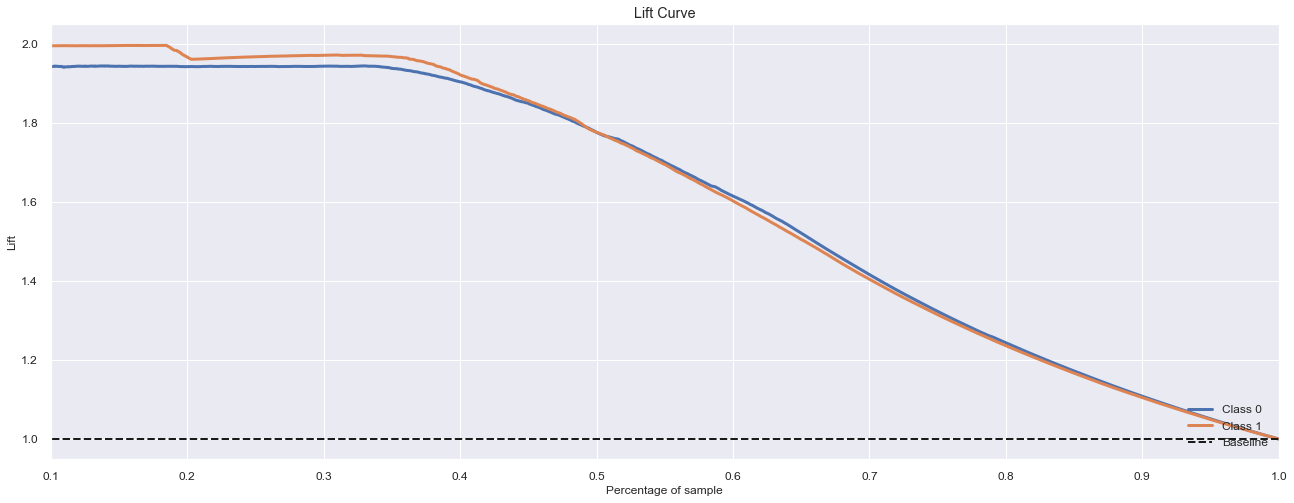

In [143]:
skplt.metrics.plot_lift_curve(xtree_yval_bal, xtree_predict_bal)
plt.xlim(0.1, 1.0);

#### Validation Set

In [144]:
xtree_val_bal = ExtraTreesClassifier(n_estimators=40, n_jobs=-1, random_state=42, 
                             verbose=0, class_weight='balanced').fit(X_train_bal, y_train_bal)

In [145]:
xtree_predict_bal_val = xtree_val_bal.predict_proba(X_val)

In [146]:
xtree_precision_bal, _ = precision_at_k(df3_val, xtree_predict_bal_val, k=20000)
xtree_precision_bal

0.25798710064496777

In [147]:
xtree_recall_bal, _ = recall_at_k(df3_val, xtree_predict_bal_val, k=20000)
xtree_recall_bal

0.5665349143610013

## LightGBM

In [148]:
lgbm = LGBMClassifier( n_estimators=10, n_jobs=-1, random_state=42)

### Imbalanced LightGBM

In [149]:
lgbm_metrics_imb, lgbm_predict_imb, lgbm_yval_imb = cross_validation(lgbm, X_train_imb, y_train_imb, num_fold=5, at_k=20000)
lgbm_metrics_imb

Cross-Validation -> Fold: 1/5 - Precision: 0.2918 / Recall: 0.8924
Cross-Validation -> Fold: 2/5 - Precision: 0.2922 / Recall: 0.8939
Cross-Validation -> Fold: 3/5 - Precision: 0.2904 / Recall: 0.8882
Cross-Validation -> Fold: 4/5 - Precision: 0.291 / Recall: 0.8902
Cross-Validation -> Fold: 5/5 - Precision: 0.2924 / Recall: 0.8943


{'precision': 0.2915754212289386, 'recall': 0.8917942591451993}

#### Validation Data

In [150]:
lgbm_val_imb = LGBMClassifier( n_estimators=100, n_jobs=-1, random_state=42).fit(X_train_imb, y_train_imb)

lgbm_predict_imb_val = lgbm_val_imb.predict_proba(X_val)

lgbm_precision_imb, _ = precision_at_k(df3_val, lgbm_predict_imb_val, k=20000)
lgbm_recall_imb, _ = recall_at_k(df3_val, lgbm_predict_imb_val, k=20000)

print(lgbm_precision_imb)
print(lgbm_recall_imb)

0.32893355332233387
0.7223320158102767


### Balanced LightGBM

In [151]:
lgbm_metrics_bal, lgbm_predict_bal, lgbm_yval_bal = cross_validation(lgbm, X_train_bal, y_train_bal, num_fold=5, at_k=20000)
lgbm_metrics_bal

Cross-Validation -> Fold: 1/5 - Precision: 0.9774 / Recall: 0.4255
Cross-Validation -> Fold: 2/5 - Precision: 0.987 / Recall: 0.4297
Cross-Validation -> Fold: 3/5 - Precision: 0.9641 / Recall: 0.4198
Cross-Validation -> Fold: 4/5 - Precision: 0.9775 / Recall: 0.4256
Cross-Validation -> Fold: 5/5 - Precision: 0.9743 / Recall: 0.4242


{'precision': 0.9760511974401279, 'recall': 0.42495483140686563}

#### Validation Data

In [152]:
lgbm_val_bal = LGBMClassifier( n_estimators=100, n_jobs=-1, random_state=42).fit(X_train_bal, y_train_bal)

lgbm_predict_bal_val = lgbm_val_bal.predict_proba(X_val)

lgbm_precision_bal, _ = precision_at_k(df3_val, lgbm_predict_bal_val, k=20000)
lgbm_recall_bal, _ = recall_at_k(df3_val, lgbm_predict_bal_val, k=20000)

print(lgbm_precision_bal)
print(lgbm_recall_bal)

0.2583370831458427
0.5673034694773825


## Catboost

In [153]:
cboost = CatBoostClassifier(iterations=20, verbose=0, random_state=42)

### Imbalanced CatBoost

In [154]:
cboost_metrics_imb, cboost_predict_imb, cboost_yval_imb = cross_validation(cboost, X_train_imb, y_train_imb, num_fold=5, at_k=20000)
cboost_metrics_imb

Cross-Validation -> Fold: 1/5 - Precision: 0.2925 / Recall: 0.8946
Cross-Validation -> Fold: 2/5 - Precision: 0.2919 / Recall: 0.8929
Cross-Validation -> Fold: 3/5 - Precision: 0.2918 / Recall: 0.8925
Cross-Validation -> Fold: 4/5 - Precision: 0.2901 / Recall: 0.8873
Cross-Validation -> Fold: 5/5 - Precision: 0.2939 / Recall: 0.8989


{'precision': 0.29205539723013846, 'recall': 0.8932621630836014}

#### Validation Data

In [155]:
cboost_val_imb = CatBoostClassifier(iterations=20, verbose=0, random_state=42).fit(X_train_imb, y_train_imb)

cboost_predict_imb_val = cboost_val_imb.predict_proba(X_val)

cboost_precision_imb, _ = precision_at_k(df3_val, cboost_predict_imb_val, k=20000)
cboost_recall_imb, _ = recall_at_k(df3_val, cboost_predict_imb_val, k=20000)

print(cboost_precision_imb)
print(cboost_recall_imb)

0.328133593320334
0.7205753184014053


### Balanced Catboost

In [156]:
cboost_metrics_bal, cboost_predict_bal, cboost_yval_bal = cross_validation(cboost, X_train_bal, y_train_bal, num_fold=5, at_k=20000)
cboost_metrics_bal

Cross-Validation -> Fold: 1/5 - Precision: 0.9898 / Recall: 0.4309
Cross-Validation -> Fold: 2/5 - Precision: 0.9931 / Recall: 0.4324
Cross-Validation -> Fold: 3/5 - Precision: 0.9936 / Recall: 0.4326
Cross-Validation -> Fold: 4/5 - Precision: 0.9932 / Recall: 0.4324
Cross-Validation -> Fold: 5/5 - Precision: 0.9887 / Recall: 0.4304


{'precision': 0.991660416979151, 'recall': 0.43175079997387844}

#### Validation Data

In [157]:
cboost_val_bal = CatBoostClassifier(iterations=20, verbose=0, random_state=42).fit(X_train_imb, y_train_imb)

cboost_predict_bal_val = cboost_val_bal.predict_proba(X_val)

cboost_precision_bal, _ = precision_at_k(df3_val, cboost_predict_bal_val, k=20000)
cboost_recall_bal, _ = recall_at_k(df3_val, cboost_predict_bal_val, k=20000)

print(cboost_precision_bal)
print(cboost_recall_bal)

0.328133593320334
0.7205753184014053


# Compare Model Performance

By results showed below, we can see that:
* XGBoost had better performance in two situations: imbalanced data with cross validation and balanced data with cross validation;
* LightGBM had better performance in imbalanced data with the validation dataset; and
* CatBoost had better performance in balanced data with the validation dataset.

This way, it's pratically impossible to say which model is the best and I could not have a conclusive answer about that at this point. Besides that, mainly in the validation dataset, several models overfitted and I will need to check why that happened.

So, I will start a new iteration to get better insights and use the new features to see if I can obtain better results.

## Imbalanced Data

**Cross Validation**

In [158]:
imb_metrics = pd.DataFrame({'LogReg': [lr_metrics_imb['precision'], lr_metrics_imb['recall']],
                           'RF': [rf_metrics_imb['precision'], rf_metrics_imb['recall']],
                           'XGB': [xgb_metrics_imb['precision'], xgb_metrics_imb['recall']],
                           'Xtree': [xtree_metrics_imb['precision'], xtree_metrics_imb['recall']],
                           'LGBM': [lgbm_metrics_imb['precision'], lgbm_metrics_imb['recall']],
                           'CBoost': [cboost_metrics_imb['precision'], cboost_metrics_imb['recall']]}, 
                          index=['Precision', 'Recall']).T.sort_values('Precision', ascending=False)
print('Imbalance Dataset - Cross Validation')
print(imb_metrics)

Imbalance Dataset - Cross Validation
        Precision  Recall
XGB          0.29    0.90
CBoost       0.29    0.89
LGBM         0.29    0.89
LogReg       0.28    0.86
RF           0.27    0.82
Xtree        0.27    0.82


**Validation Set**

In [159]:
imb_metrics_val = pd.DataFrame({'LogReg': [lr_precision_imb, lr_recall_imb],
                                'RF': [rf_precision_imb, rf_recall_imb],
                                'XGB': [xgb_precision_imb, xgb_recall_imb],
                                'xtree': [xtree_precision_imb, xtree_recall_imb],
                                'LGBM': [lgbm_precision_imb, lgbm_recall_imb],
                                'CBoost': [cboost_precision_imb, cboost_recall_imb]},
                                index=['Precision', 'Recall']).T.sort_values('Precision', ascending=False)
print('Imbalanced Dataset - Validation')
print(imb_metrics_val)

Imbalanced Dataset - Validation
        Precision  Recall
LGBM         0.33    0.72
CBoost       0.33    0.72
XGB          0.32    0.71
LogReg       0.31    0.67
xtree        0.30    0.66
RF           0.30    0.65


## Balanced Data

**Cross Validation**

In [160]:
bal_metrics = pd.DataFrame({'LogReg': [lr_metrics_bal['precision'], lr_metrics_bal['recall']],
                            'RF': [rf_metrics_bal['precision'], rf_metrics_bal['recall']],
                            'XGB': [xgb_metrics_bal['precision'], xgb_metrics_bal['recall']],
                            'xtree': [xtree_metrics_bal['precision'], xtree_metrics_bal['recall']],
                            'LGBM': [lgbm_metrics_bal['precision'], lgbm_metrics_bal['recall']],
                            'CBoost': [cboost_metrics_bal['precision'], cboost_metrics_bal['recall']]},
                            index=['Precision', 'Recall']).T.sort_values('Precision', ascending=False)
print('Balance Dataset - Cross Validation')
print(bal_metrics)

Balance Dataset - Cross Validation
        Precision  Recall
XGB          1.00    0.44
RF           1.00    0.44
CBoost       0.99    0.43
xtree        0.98    0.43
LGBM         0.98    0.42
LogReg       0.78    0.34


**Validation Set**

In [161]:
bal_metrics_val = pd.DataFrame({'LogReg': [lr_precision_bal, lr_recall_bal],
                                'RF': [rf_precision_bal, rf_recall_bal],
                                'XGB': [xgb_precision_bal, xgb_recall_bal],
                                'xtree': [xtree_precision_bal, xtree_recall_bal],
                                'LGBM': [lgbm_precision_bal, lgbm_recall_bal],
                                'CBoost': [cboost_precision_bal, cboost_recall_bal]},
                                index=['Precision', 'Recall']).T.sort_values('Precision', ascending=False)
print('Balanced Dataset - Validation')
bal_metrics_val

Balanced Dataset - Validation


,Precision,Recall
CBoost,0.33,0.72
LogReg,0.31,0.67
RF,0.27,0.60
LGBM,0.26,0.57
xtree,0.26,0.57
XGB,0.21,0.46


**<font color='blue'>The steps bellow will be accomplished in the next iterations of the process.</font>**

# Hyperparameter fine tunning

# Final Model

# <font color='red'>5. Evaluation: Metrics and Error Interpretation</font>

# Business Performance

# Total Performance

# Machine Learning Performance

# <font color='red'>6. Deployment</font>

# Deploy to Production

## Class

## API Handler

## API Tester